# Modelling

In this notebook we will take the amazon instrument reviews and predict their sentiment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

seed = 2
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import random
random.seed(seed)

In [2]:
df = pd.read_pickle('pre-processed_data.pkl')

df.head()

,helpful,reviewText,summary,reviewRating
0,0.000000,"[much, write, here, ,, exactly, supposed, to, ...",[good],good
1,0.928571,"[product, exactly, quite, affordable.i, realiz...",[jake],good
2,1.000000,"[primary, job, device, block, breath, would, o...","[job, well]",good
3,0.000000,"[nice, windscreen, protects, mxl, mic, prevent...","[good, windscreen, money]",good
4,0.000000,"[pop, filter, great, ., look, performs, like, ...","[pop, record, vocals, .]",good


First we need to split the data into training and testing sets.

In [3]:
#we need to put the strings back together
df['reviewText'] = df['reviewText'].str.join(' ')
df['summary'] = df['summary'].str.join(' ')

In [4]:
#X = df[['reviewText', 'summary']]
#concatenate the two text columns to get our X data
X = df['reviewText'] + ' ' + df['summary']
y = df['reviewRating']

#keeping the sentiments here in case we need them for any data analysis
X_train, X_test, y_train_sent, y_test_sent = train_test_split(X, y, test_size=0.25, random_state=seed)

## Bag of Words

First we will try bag of words, with the Term Frequency-Inverse Document Frequency vectorizer in python. We will use two models, the naive bayes model and a support vector machine, since these two are typically considered to be good for sentiment analysis tasks. 

For the metric, the accuracy and F1 score are usually metrics used in sentiment problems. Because this data is very imblanced though, we will use the weighted F1 score.

Here we will get the data. We have to fit and transform two text features, so we can do them seperately and then concatenate them back into one dataframe, which will be the X data.

In [5]:
tfidf = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))

tfidf_X_train = tfidf.fit_transform(X_train)
tfidf_X_test = tfidf.transform(X_test)

In [6]:
tfidf_X_train

<7695x212105 sparse matrix of type '<class 'numpy.float64'>'
	with 212105 stored elements in Compressed Sparse Row format>

Now let's encode the target variable.

In [7]:
#get the y labels as numbers so we can predict them
le = LabelEncoder()
y_train = le.fit_transform(y_train_sent)
y_test = le.transform(y_test_sent)

Note that here now we have that: 0 is bad, 1 is good, and 2 is neutral.

### Naive Bayes

The multinomial Naive Bayes is typically what is used for text classification, like this problem. We will use that now. Let's try the base model first.

In [8]:
nb = MultinomialNB()

nb_tfidf = nb.fit(tfidf_X_train, y_train)

In [9]:
nb_tfidf_predict = nb.predict(tfidf_X_test)

In [10]:
nb.score(tfidf_X_train, y_train)

0.8796621182586095

In [11]:
nb.score(tfidf_X_test, y_test)

0.882307092751364

In [12]:
confusion_matrix(y_test, nb_tfidf_predict)

array([[   0,  107,    0],
       [   0, 2264,    0],
       [   0,  195,    0]], dtype=int64)

So the basic model predicts only good sentiments. This makes sense since the data is heavily skewed that way. This next function is a function that will plot a scoring metric for a range of a certain parameter value. Essentially mimicing gridsearch for one hyperparameter. There is only one hyperparameter here, so we can just look at that, being alpha.

In [69]:
#function that plots a score against parameter values, to allow us to visualize how a certain parameter affects the score
def plot_train_val_scores(model, param_name, param_range, logplot = False, scoring_metric='f1_macro', y_label='f1 score'):
    #using the validation_curve function to get the score values
    train_scores, valid_scores = validation_curve(model, tfidf_X_train, y_train, 
                                                  param_name=param_name, 
                                                  param_range=param_range, 
                                                  cv=5,
                                                  scoring=scoring_metric, 
                                                  n_jobs=-1)
    
    #take the mean of the cross validation scores and plot these
    train_scores_mean = train_scores.mean(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)
    
    #if the var_smoothing parameter ranges increase exponentially, we need to take the log of it to get a better visual
    if logplot:
        plt.semilogx(param_range, train_scores_mean, label="Training score")
        plt.semilogx(param_range, valid_scores_mean, label="Validation score")
    else:
        plt.plot(param_range, train_scores_mean, label="Training score")
        plt.plot(param_range, valid_scores_mean, label="Validation score")
    
    plt.title('Training and validation scores for {} parameter values'.format(param_name))
    plt.xlabel('parameter range')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

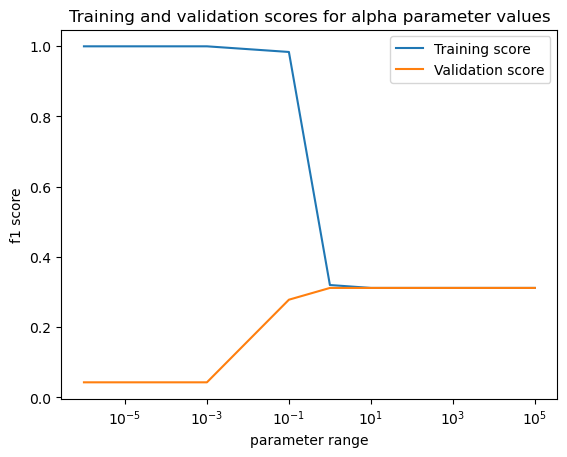

In [70]:
parameter_range = [0.000001, 0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000, 100000]

plot_train_val_scores(MultinomialNB(), 'alpha', parameter_range, logplot = True)

Not too much happening here. Perhaps taking closer look around the value of 1 will give better ideas on what the optimal alpha value is.

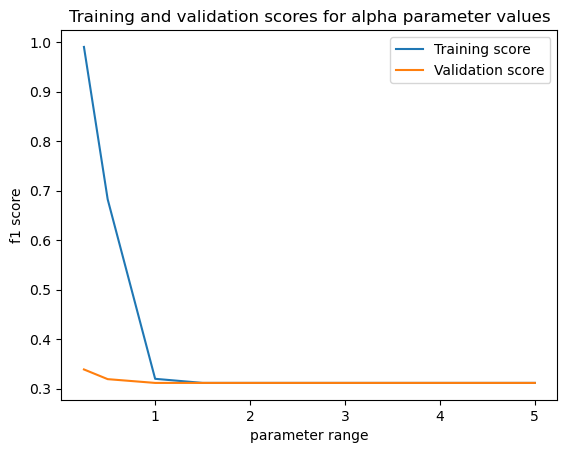

In [71]:
parameter_range = [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]

plot_train_val_scores(MultinomialNB(), 'alpha', parameter_range, logplot = False)

Alpha=2 is probably the best here, but anything above it would be fine as well.

In [115]:
nb = MultinomialNB(alpha=2)

nb_tfidf = nb.fit(tfidf_X_train, y_train)

nb_tfidf_predict = nb.predict(tfidf_X_test)

f1_score_nb = f1_score(nb_tfidf_predict, y_test, average = 'macro')
print('Final weighted f1 score for naive bayes model is:', f1_score_nb)

Final weighted f1 score for naive bayes model is: 0.31249137336093863


Now let's look at the confusion matrix. First, we can build a function to avoid repeating the plotting code for the confusion matrix.

In [67]:
def plot_con_mat(y_test, y_pred, title):
    con_mat = confusion_matrix(y_test, y_pred)

    sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
                xticklabels = ["bad", "good", "neutral"], yticklabels = ["bad", "good", "neutral"])
    plt.xlabel('predicted', fontsize=16)
    plt.ylabel('actual', fontsize=16)
    plt.title(title, fontsize=18)
    plt.show()

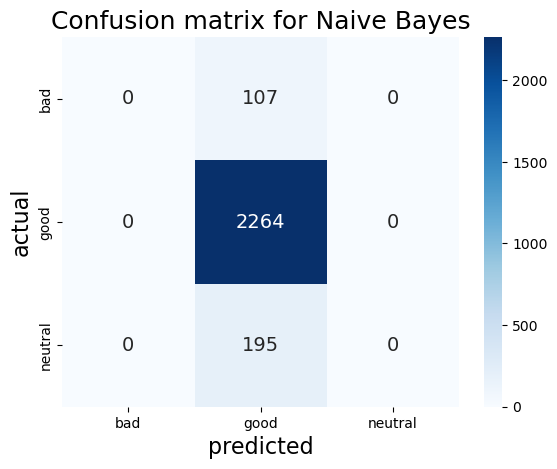

In [116]:
#now let's get the confusion matrix to see how it does
plot_con_mat(y_test, nb_tfidf_predict, 'Confusion matrix for Naive Bayes')

Unfortunately, the best model here still only predicts the good sentiment. Let's try another one.

### Support Vector Machine

A support vector classifier is also used for text classification sometimes, so maybe it will be decent here.

In [29]:
svc = SVC()

In [30]:
svc_tfidf = svc.fit(tfidf_X_train, y_train)

In [31]:
svc_tfidf_predict = svc.predict(tfidf_X_test)

In [32]:
svc.score(tfidf_X_train, y_train)

0.8791423001949318

In [34]:
parameters = {'C': [0.01, 0.1, 1, 10], 
              'degree': [3, 5, 7], 
              'class_weight': [None, 'balanced']
             }

svc = SVC(random_state=seed)

clf = GridSearchCV(svc, parameters, n_jobs=-1, scoring='f1_weighted')

clf.fit(tfidf_X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'degree': [3, 5, 7]},
             scoring='f1_weighted')

In [35]:
clf.best_params_

{'C': 0.01, 'class_weight': None, 'degree': 3}

In [36]:
print('SVC training f1 score after gridsearch is:', clf.score(tfidf_X_train, y_train))
print('SVC testing f1 score after gridsearch is:', clf.score(tfidf_X_test, y_test))

SVC training score after gridsearch is: 0.8225999530869589
SVC testing score after gridsearch is: 0.8232262303792768


Now let's explore the the parameters individually a bit more. Both the C and degree parameters had optimal values less at the bottom range, so we know where to explore next.

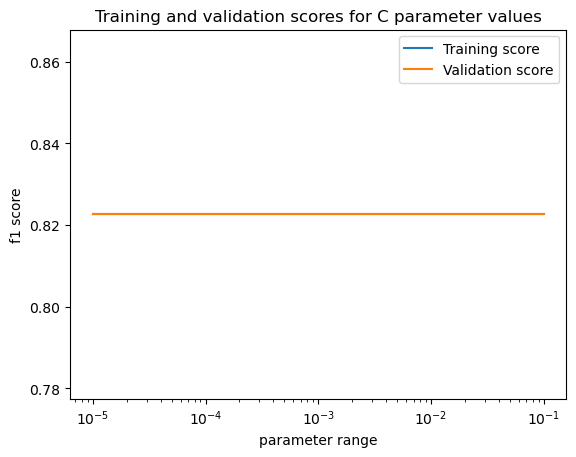

In [33]:
parameter_range = [0.00001, 0.0001, 0.001, 0.1]

plot_train_val_scores(SVC(degree=3, random_state=42), 'C', parameter_range, logplot = True)

It looks like the C value's don't even make a difference. As it turns out, this is because the model is only predicting the dominant sentiment, being good. Thus, until the model can do a better job, these scores will always be what we see here.

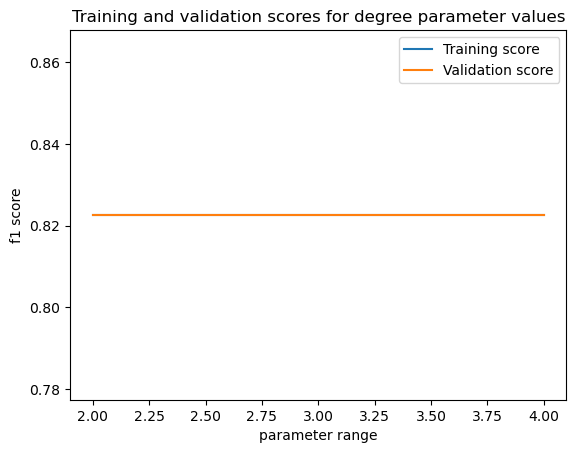

In [38]:
parameter_range = [2, 3, 4]

plot_train_val_scores(SVC(C=0.01, random_state=42), 'degree', parameter_range, logplot = False)

Same issue as before. Let's build the model from gridsearch and show the confusion matrix, to see how this model can't detect the neutral or bad sentiments.

In [97]:
svc = SVC(C=0.01, degree=3, random_state=seed)

svc.fit(tfidf_X_train, y_train)

svc_tfidf_predict = svc.predict(tfidf_X_test)

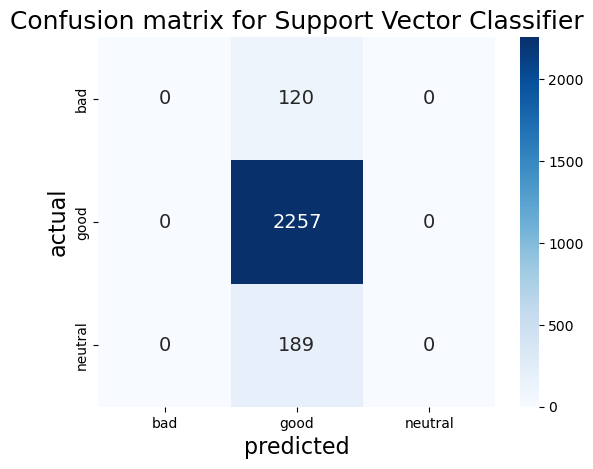

In [98]:
#now let's get the confusion matrix to see how it does
con_mat = confusion_matrix(y_test, svc_tfidf_predict)

sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["bad", "good", "neutral"], yticklabels = ["bad", "good", "neutral"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for Support Vector Classifier', fontsize=18)
plt.show()

### Neural Network

Seems like the models above just are not good enough to handle this unbalanced dataset. Perhaps neural network models can be useful then. First we will try an architecture without LSTM's, and then with. To start off here, we need to do some different pre-processing steps, including tokenizing the text, and then padding them.

In [17]:
# don't want vocab size to be too large
max_vocab = 5000

tokenizer = Tokenizer(max_vocab)

In [18]:
tokenizer.fit_on_texts(X_train)

In [19]:
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

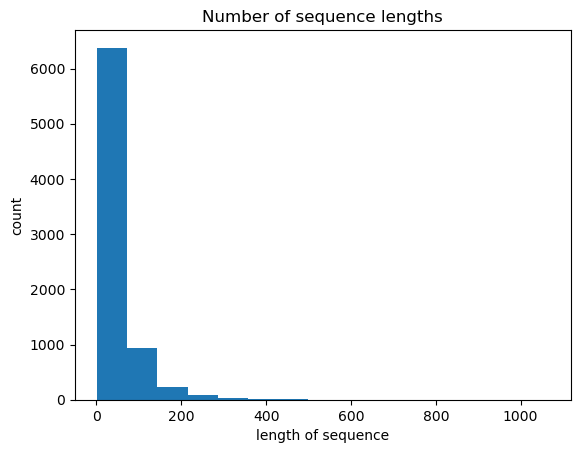

In [20]:
plt.hist([len(seq) for seq in train_sequence], bins = 15)
plt.title('Number of sequence lengths')
plt.ylabel('count')
plt.xlabel('length of sequence')
plt.show()

So this plot tells us most sequences are of length 500 or less. For the padding we can set the max length to 500 then.

In [21]:
padded_train_sequence = pad_sequences(train_sequence, maxlen=500)
padded_test_sequence = pad_sequences(test_sequence, maxlen=500)

padded_train_sequence.shape

(7695, 500)

In [22]:
#we also need to one-hot encode the y data for keras
yy_train = to_categorical(y_train)
yy_test = to_categorical(y_test)

Let's use a sequential model here, starting off with an embedding layer, as is standard for text data. Not super sure what metric is best, so we will look at a few for now. 

In [159]:
#building model, mostly via trail and error
model=Sequential()
model.add(Embedding(max_vocab, 1000, input_length=500))
model.add(GlobalAveragePooling1D())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))

#getting the metrics, some from tensorflow add ons
f1_score_macro = tfa.metrics.F1Score(num_classes=3, average='macro', name = 'f1_macro')
f1_score_weighted = tfa.metrics.F1Score(num_classes=3, average='weighted', name = 'f1_weighted')
kappa = tfa.metrics.CohenKappa(num_classes=3, weightage = None, name = 'kappa')
matthew = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

#categorical_crossentropy is for multiclassification, but we need one hot-encoded targets, which we did above
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])

In [160]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 500, 1000)         5000000   
                                                                 
 global_average_pooling1d_14  (None, 1000)             0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_47 (Dense)            (None, 32)                32032     
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 3)                 99        
                                                                 
Total params: 5,032,131
Trainable params: 5,032,131
Non-trainable params: 0
___________________________________________

In [161]:
model.fit(padded_train_sequence, 
          yy_train,
          validation_split = 0.25,
          batch_size = 32,
          epochs = 12,
          class_weight = None
         )

Epoch 1/12
181/181 [==============================] - 5s 19ms/step - loss: 0.5197 - accuracy: 0.8777 - f1_macro: 0.3156 - f1_weighted: 0.8215 - kappa: 0.0042 - MatthewsCorrelationCoefficient: 0.0239 - val_loss: 0.4441 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/12
181/181 [==============================] - 3s 15ms/step - loss: 0.4653 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4381 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/12
181/181 [==============================] - 3s 15ms/step - loss: 0.4487 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4219 - val_accuracy: 0.8789 - val_f1_macro: 0

In [166]:
def plot_metric_history(metrics, suptitle = 'Evaluation metrics'):
    fig, axes = plt.subplots(2, 2, figsize=(12,8))

    #axes[0, 0].plot(metrics['accuracy'])
    #axes[0, 0].plot(metrics['val_accuracy'])
    #axes[0, 0].set_title('accuracy')

    axes[0, 0].plot(metrics['f1_macro'])
    axes[0, 0].plot(metrics['val_f1_macro'])
    axes[0, 0].set_title('f1_macro')

    axes[0, 1].plot(metrics['f1_weighted'])
    axes[0, 1].plot(metrics['val_f1_weighted'])
    axes[0, 1].set_title('f1_weighted')

    axes[1, 0].plot(metrics['kappa'])
    axes[1, 0].plot(metrics['val_kappa'])
    axes[1, 0].set_title('cohen_kappa')

    axes[1, 1].plot(metrics['MatthewsCorrelationCoefficient'])
    axes[1, 1].plot(metrics['val_MatthewsCorrelationCoefficient'])
    axes[1, 1].set_title('Matthews Correlation Coefficient')
    
    plt.suptitle(suptitle)

    plt.show()

KeyError: 'f1_macro'

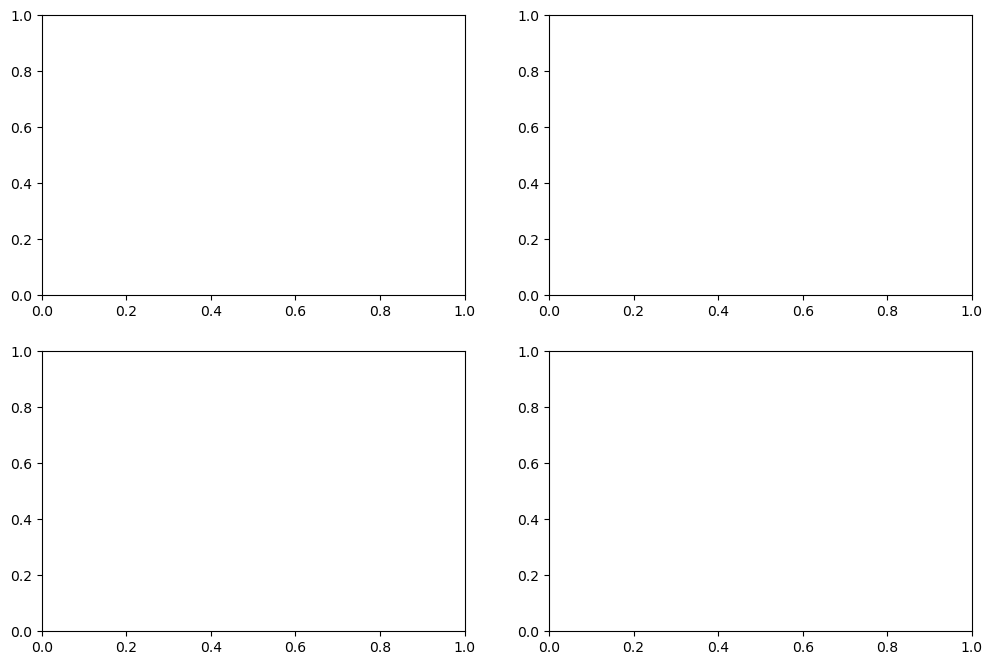

In [167]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

In [190]:
#we will do this step a lot, so makinga  function to save a few lines of code
def get_test_predictions(X_test, NN_model):
    y_pred = NN_model.predict(X_test)

    #the model predicts probablilites, so we need to turn them into classes by taking the largest probability
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [169]:
y_pred_classes = get_test_predictions(padded_test_sequence)

#check to see if the model is at least predicting not just one sentiment
Counter(y_pred_classes)

81/81 [==============================] - 0s 4ms/step


Counter({1: 2407, 2: 45, 0: 114})

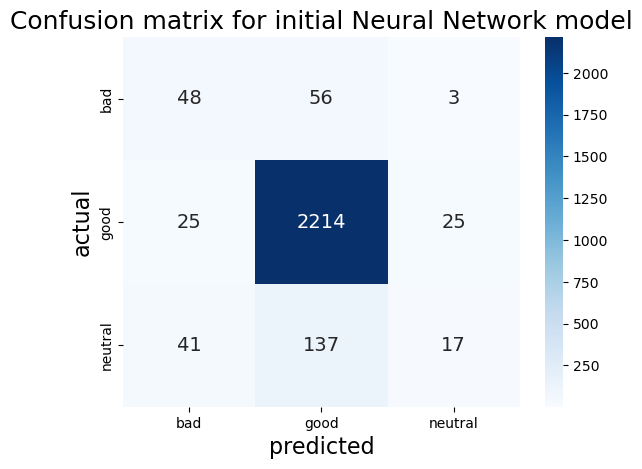

              precision    recall  f1-score   support

           0       0.42      0.45      0.43       107
           1       0.92      0.98      0.95      2264
           2       0.38      0.09      0.14       195

    accuracy                           0.89      2566
   macro avg       0.57      0.50      0.51      2566
weighted avg       0.86      0.89      0.87      2566



In [170]:
plot_con_mat(y_test, y_pred_classes, 'Confusion matrix for initial Neural Network model')

print(classification_report(y_test, y_pred_classes))

Seems like the f1 score is stabilizing after epoch 5 for the test set, while the training set f1 score continues to rise. From this, stopping at epoch 5 or 6 would probably be best. Although, from some initial testing something odd seems to be happening, where after 5 or so epochs the F1 score will stabilize, but the confusion matrices will look different after each epoch, and start worse around 5 epochs (not predict one of the classes very much), then get better, and then worse again. At least that is what is seems like. Let's look at this more closely.

In [171]:
#here is our model as a function
def buildmodel(learning_rate = 0.001, dropout = 0.3):
    model= Sequential([
        Embedding(max_vocab, 1000, input_length=500),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(3,activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])
    
    return model

In [175]:
def build_model_con_mat(epoch = 6, batch_size = 32, learning_rate = 0.001, plot_metrics = False):
    model = buildmodel(learning_rate = learning_rate)

    model.fit(padded_train_sequence, 
              yy_train,
              validation_split = 0.25,
              batch_size = batch_size,
              epochs = epoch)
    
    metrics = pd.DataFrame(model.history.history)
    
    y_pred = get_test_predictions(padded_test_sequence)

    plot_con_mat(y_test, y_pred, 'Confusion matrix for model with {} epochs, batch_size = {}, and learning_rate = {}'.format(epoch, batch_size, learning_rate))
    
    if plot_metrics:
        #plot the metrics
        plot_metric_history(
            metrics, 
            suptitle = 'Metrics for model with {} epochs, batch_size = {}, and learning_rate = {}'.format(epoch, batch_size, learning_rate))
    

Epoch 1/4
181/181 [==============================] - 4s 18ms/step - loss: 0.5139 - accuracy: 0.8730 - f1_macro: 0.3107 - f1_weighted: 0.8175 - kappa: -0.0036 - MatthewsCorrelationCoefficient: -0.0101 - val_loss: 0.4436 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/4
181/181 [==============================] - 3s 15ms/step - loss: 0.4612 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4382 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/4
181/181 [==============================] - 3s 15ms/step - loss: 0.4493 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4264 - val_accuracy: 0.8789 - val_f1_macro: 0.

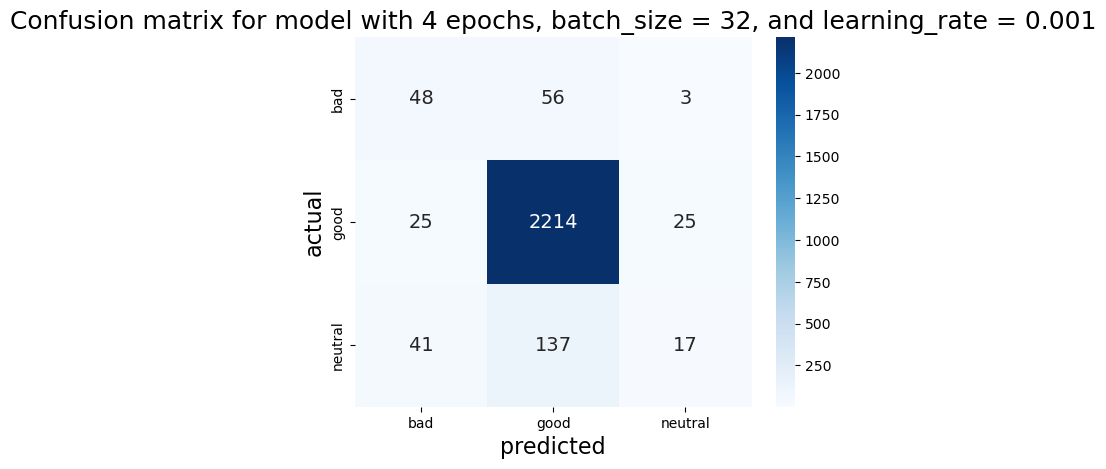

Epoch 1/6
181/181 [==============================] - 4s 18ms/step - loss: 0.5188 - accuracy: 0.8735 - f1_macro: 0.3166 - f1_weighted: 0.8206 - kappa: 0.0020 - MatthewsCorrelationCoefficient: 0.0058 - val_loss: 0.4446 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/6
181/181 [==============================] - 3s 15ms/step - loss: 0.4657 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4384 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/6
181/181 [==============================] - 3s 15ms/step - loss: 0.4508 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4192 - val_accuracy: 0.8789 - val_f1_macro: 0.31

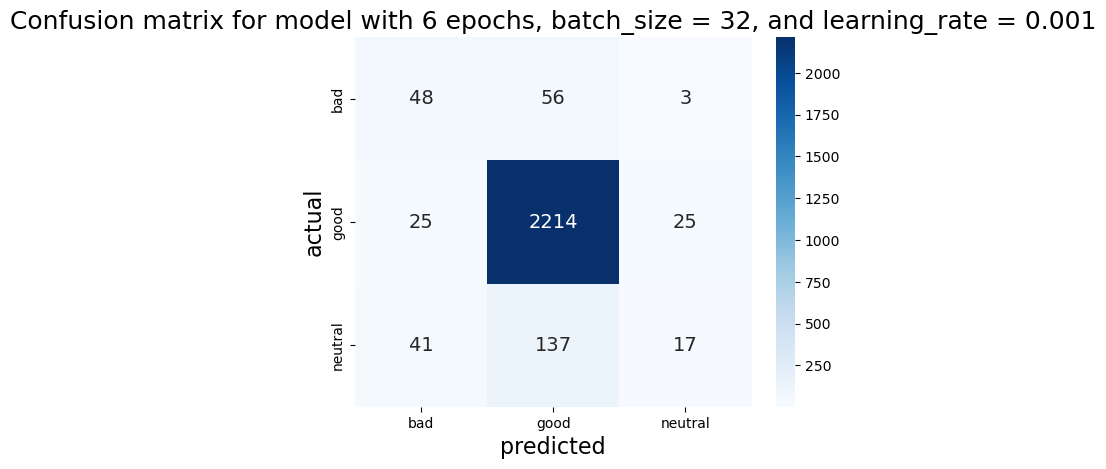

Epoch 1/8
181/181 [==============================] - 4s 18ms/step - loss: 0.5095 - accuracy: 0.8716 - f1_macro: 0.3540 - f1_weighted: 0.8275 - kappa: 0.0612 - MatthewsCorrelationCoefficient: 0.1015 - val_loss: 0.4437 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/8
181/181 [==============================] - 3s 15ms/step - loss: 0.4645 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4388 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/8
181/181 [==============================] - 3s 14ms/step - loss: 0.4473 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4260 - val_accuracy: 0.8789 - val_f1_macro: 0.31

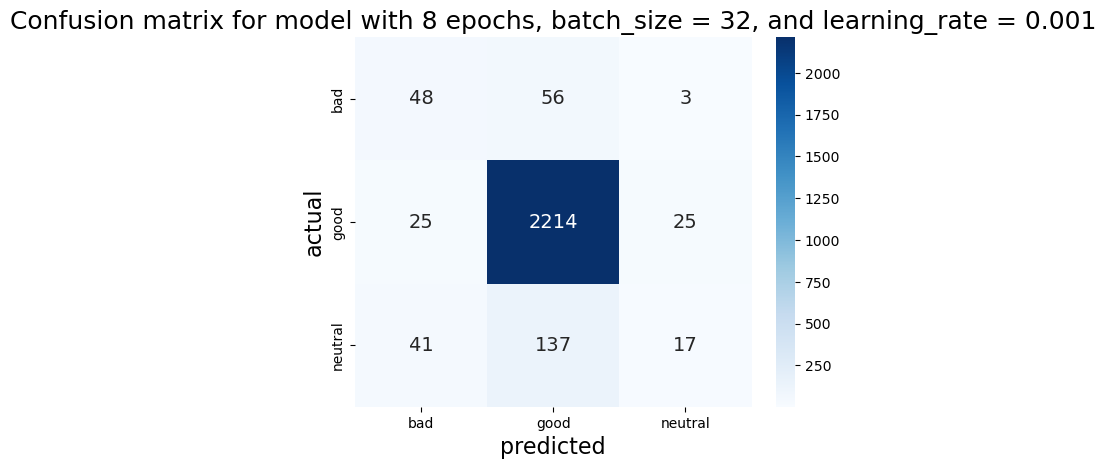

Epoch 1/10
181/181 [==============================] - 4s 19ms/step - loss: 0.5352 - accuracy: 0.8768 - f1_macro: 0.3844 - f1_weighted: 0.8340 - kappa: 0.1083 - MatthewsCorrelationCoefficient: 0.1659 - val_loss: 0.4452 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
181/181 [==============================] - 3s 15ms/step - loss: 0.4758 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4403 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/10
181/181 [==============================] - 3s 16ms/step - loss: 0.4622 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4328 - val_accuracy: 0.8789 - val_f1_macro: 0

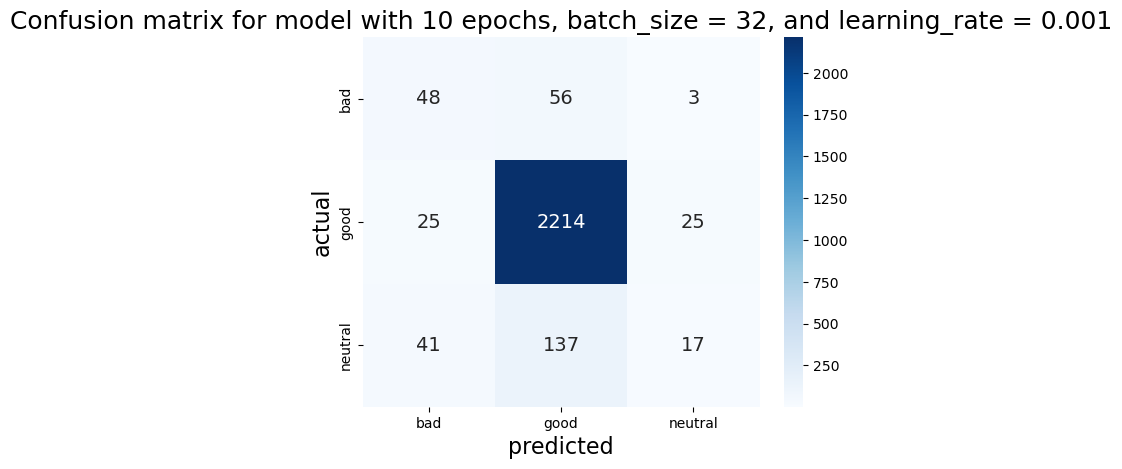

Epoch 1/12
181/181 [==============================] - 4s 19ms/step - loss: 0.5249 - accuracy: 0.8759 - f1_macro: 0.3722 - f1_weighted: 0.8321 - kappa: 0.0813 - MatthewsCorrelationCoefficient: 0.1505 - val_loss: 0.4437 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/12
181/181 [==============================] - 3s 15ms/step - loss: 0.4631 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4384 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/12
181/181 [==============================] - 3s 15ms/step - loss: 0.4483 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4307 - val_accuracy: 0.8789 - val_f1_macro: 0

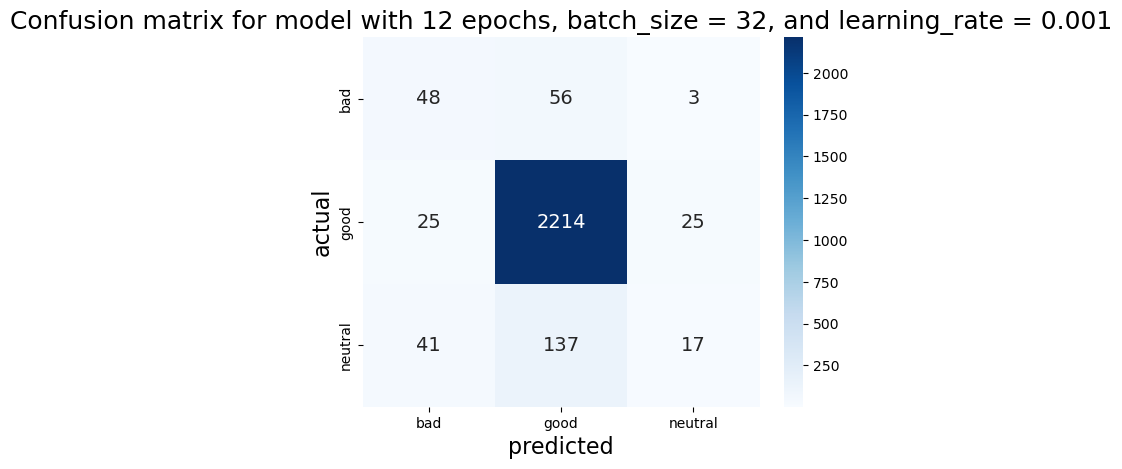

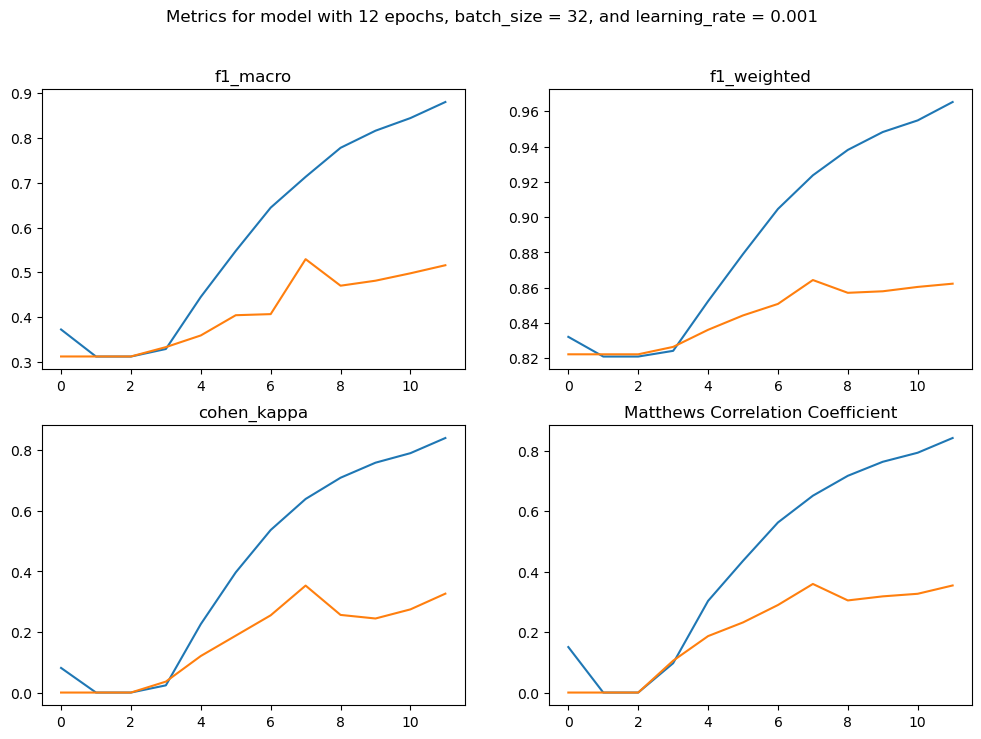

In [176]:
epoch_range = list(range(4, 14, 2))

for e in epoch_range:
    #don't want to print the metric plots for every iteration, to keep things readable
    if e == epoch_range[-1]:
        plot_metrics = True
    else:
        plot_metrics = False
    build_model_con_mat(epoch = e, plot_metrics = plot_metrics)

So the confusion matrix doesn't predict the bad sentiment too well with less epochs. It gets better with more, but starts to get worse again with mroe epochs, all while the evaluation metrics remain stabilized. Even with the simplist model (and dropout layers), overfitting remains a big issue, so let's try adding more data. Specifically, we can up scale the data so that it is more balanced.

Upscaling methods were burrowed from here: https://www.kaggle.com/code/sanjay11100/lstm-sentiment-analysis-data-imbalance-keras. Here, since we are focusing on tuning the model as well, we will split the training data into it's own training and validation data.

In [26]:
#putting the training data back together to filter for each sentiment
mod_df = pd.concat([X_train, y_train_sent], axis=1)
mod_df.rename({0: 'text'}, axis=1, inplace = True)

mod_df.head()

,text,reviewRating
357,one awesome guitar ! also purchased fender mus...,good
9031,dont often use pick soprano uke . mahalo pick ...,good
8893,"one best , simple use , guitar tuner ive used ...",good
2529,absolutely obligatory fan rock n roll jamming ...,neutral
8332,tuner work great . vibration mic.only real pro...,bad


In [27]:
#seperating the sentiments.
good_df = mod_df[mod_df['reviewRating'] == 'good']
neutral_df = mod_df[mod_df['reviewRating'] == 'neutral']
bad_df = mod_df[mod_df['reviewRating'] == 'bad']

In [29]:
#geting the new training sets, per sentiment - same ratio for each
train_good = good_df.sample(frac=0.75, random_state=seed)
train_neutral = neutral_df.sample(frac=0.75, random_state=seed)
train_bad = bad_df.sample(frac=0.75, random_state=seed)

#putting them together to get our new training dataframe
train_df = pd.concat([train_good, train_neutral, train_bad])

#this drops the training data from the df's above, 
#so the 25% that isn't in the training dataframe will be our validation data
val_df = pd.concat([good_df.drop(train_good.index), neutral_df.drop(train_neutral.index), bad_df.drop(train_bad.index)])

In [30]:
# Upsample minority classes
train_neutral_upsampled = resample(train_neutral, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_good.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

train_bad_upsampled = resample(train_bad, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_good.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

#down sample to match the bad sentiment, which has the least samples
train_good_downsampled = resample(train_good, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_bad.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

train_neutral_downsampled = resample(train_neutral, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_bad.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

In [32]:
#now putting the training dataframes together for the upsampled and downsampled versions each
train_df_upsampled = pd.concat([train_good, train_neutral_upsampled, train_bad_upsampled])
print(train_df_upsampled.shape)

train_df_downsampled = pd.concat([train_bad, train_neutral_downsampled, train_good_downsampled])
print(train_df_downsampled.shape)

(15204, 2)
(810, 2)


In [33]:
#can do this step again, but unnecessary if ran it above
#tokenizer = Tokenizer(max_vocab)
#tokenizer.fit_on_texts(X_train)

Now we must pre-process the training data again, for all the different versions.

In [34]:
#split the normal training data into x and y, just for comparison
X_train_not_upsampled = train_df['text']
y_train_not_upsampled = train_df['reviewRating']

#split the training upsampled data into x and y
X_train_upsampled = train_df_upsampled['text']
y_train_upsampled = train_df_upsampled['reviewRating']

#split the training downsampled data into x and y
X_train_downsampled = train_df_downsampled['text']
y_train_downsampled = train_df_downsampled['reviewRating']

#split the validation data into x and y
X_val = val_df['text']
y_val = val_df['reviewRating']

#tokenize the text
train_sequence_not_upsampled = tokenizer.texts_to_sequences(X_train_not_upsampled)
train_sequence_upsampled = tokenizer.texts_to_sequences(X_train_upsampled)
train_sequence_downsampled = tokenizer.texts_to_sequences(X_train_downsampled)
val_sequence_upsampled = tokenizer.texts_to_sequences(X_val)

#pad the text sequences
padded_train_sequence_not_upsampled = pad_sequences(train_sequence_not_upsampled, maxlen=500)
padded_train_sequence_upsampled = pad_sequences(train_sequence_upsampled, maxlen=500)
padded_train_sequence_downsampled = pad_sequences(train_sequence_downsampled, maxlen=500)
padded_val_sequence = pad_sequences(val_sequence_upsampled, maxlen=500)

#change the y labels into numbers
y_train_not_upsampled_labels = le.transform(y_train_not_upsampled)
y_train_upsampled_labels = le.transform(y_train_upsampled)
y_train_downsampled_labels = le.transform(y_train_downsampled)
y_val_labels = le.transform(y_val)

#now turn these number labels into one-hot encoded format for keras like before
yy_train_not_upsampled = to_categorical(y_train_not_upsampled_labels)
yy_train_upsampled = to_categorical(y_train_upsampled_labels)
yy_train_downsampled = to_categorical(y_train_downsampled_labels)
yy_val = to_categorical(y_val_labels)

Something else we can test is adding class weights. which we can get from a python package is sklearn. We might not use it just yet, but it is here now just in case.

In [35]:
class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(y_train_not_upsampled_labels), 
                                     y=y_train_not_upsampled_labels)

class_weights = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}

print(class_weights)

{0: 7.124691358024691, 1: 0.3795711654827677, 2: 4.442648190916089}


Now we can see how well the upsampled or downsampled training sets do. We should start with the non-up or down sampled data first, so have have something to compare it to.

**Regular training data:**

In [208]:
model = buildmodel()

model.fit(padded_train_sequence_not_upsampled, 
          yy_train_not_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          verbose = 1)

Epoch 1/10
181/181 [==============================] - 4s 18ms/step - loss: 0.5026 - accuracy: 0.8775 - f1_macro: 0.3398 - f1_weighted: 0.8153 - kappa: 0.0358 - MatthewsCorrelationCoefficient: 0.0437 - val_loss: 0.4480 - val_accuracy: 0.8784 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8215 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
181/181 [==============================] - 3s 15ms/step - loss: 0.4623 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8212 - kappa: -1.1921e-07 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4413 - val_accuracy: 0.8784 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8215 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/10
181/181 [==============================] - 3s 15ms/step - loss: 0.4380 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8212 - kappa: -1.1921e-07 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4216 - val_accuracy: 0.8784 - val_f1_macro:

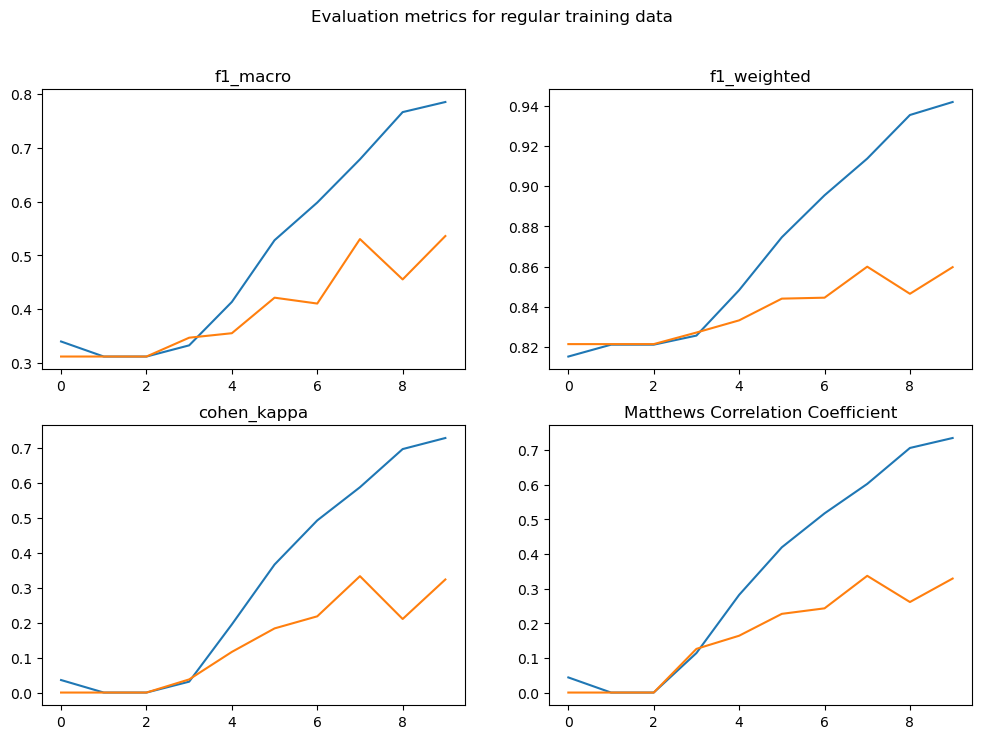

In [209]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics, suptitle = 'Evaluation metrics for regular training data')

61/61 [==============================] - 0s 2ms/step


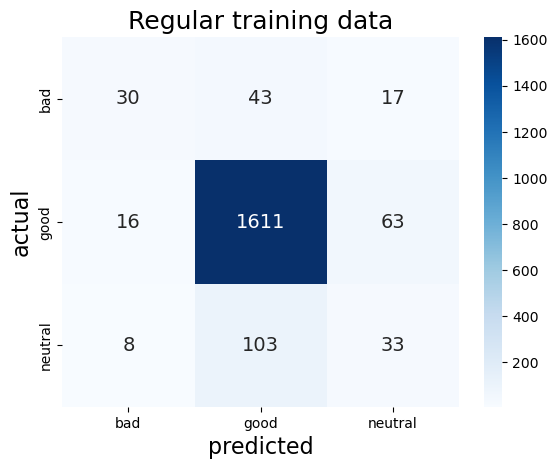

              precision    recall  f1-score   support

           0       0.56      0.33      0.42        90
           1       0.92      0.95      0.93      1690
           2       0.29      0.23      0.26       144

    accuracy                           0.87      1924
   macro avg       0.59      0.51      0.54      1924
weighted avg       0.85      0.87      0.86      1924



In [210]:
y_pred_probs = model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'Regular training data')

print(classification_report(y_val_labels, y_pred))

**Downsampled training data:**

In [205]:
model = buildmodel()

model.fit(padded_train_sequence_downsampled, 
          yy_train_downsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
26/26 [==============================] - 2s 58ms/step - loss: 1.1000 - accuracy: 0.3210 - f1_macro: 0.4232 - f1_weighted: 0.6476 - kappa: 0.2029 - MatthewsCorrelationCoefficient: 0.2057 - val_loss: 1.0954 - val_accuracy: 0.0748 - val_f1_macro: 0.0464 - val_f1_weighted: 0.0104 - val_kappa: 1.5736e-05 - val_MatthewsCorrelationCoefficient: 9.6343e-04
Epoch 2/10
26/26 [==============================] - 1s 30ms/step - loss: 1.0978 - accuracy: 0.3506 - f1_macro: 0.3330 - f1_weighted: 0.3330 - kappa: 0.0259 - MatthewsCorrelationCoefficient: 0.0270 - val_loss: 1.1418 - val_accuracy: 0.0748 - val_f1_macro: 0.0466 - val_f1_weighted: 0.0105 - val_kappa: 9.4593e-05 - val_MatthewsCorrelationCoefficient: 0.0024
Epoch 3/10
26/26 [==============================] - 1s 30ms/step - loss: 1.1004 - accuracy: 0.3198 - f1_macro: 0.2850 - f1_weighted: 0.2850 - kappa: -0.0204 - MatthewsCorrelationCoefficient: -0.0226 - val_loss: 1.0660 - val_accuracy: 0.8612 - val_f1_macro: 0.3228 - val_f1_weighted:

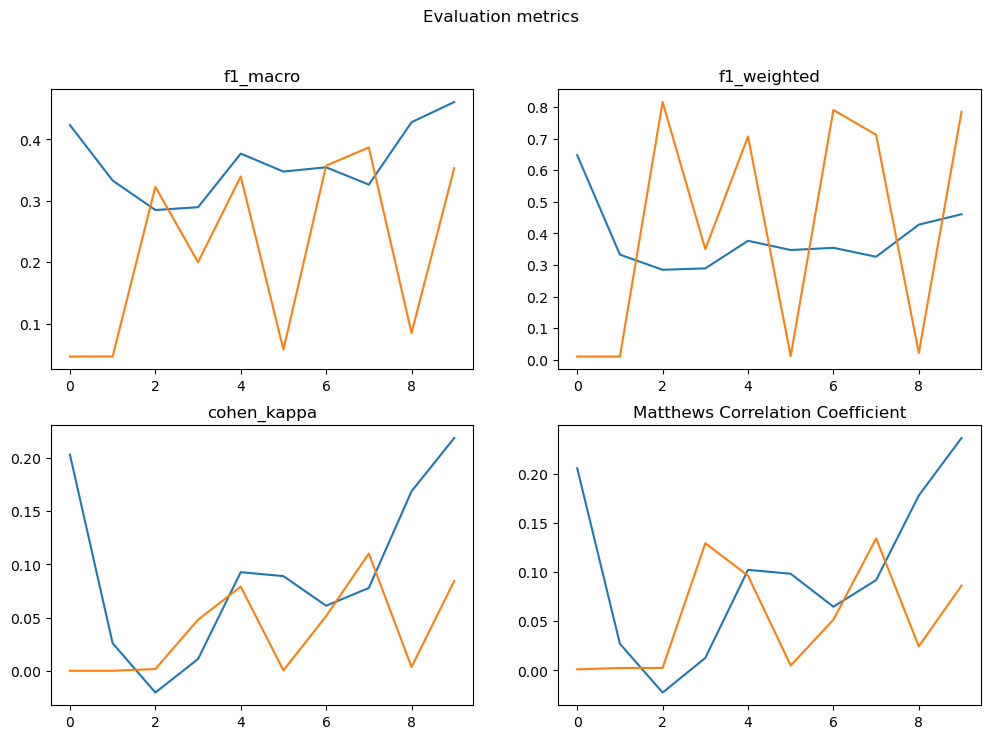

In [206]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 0s 1ms/step


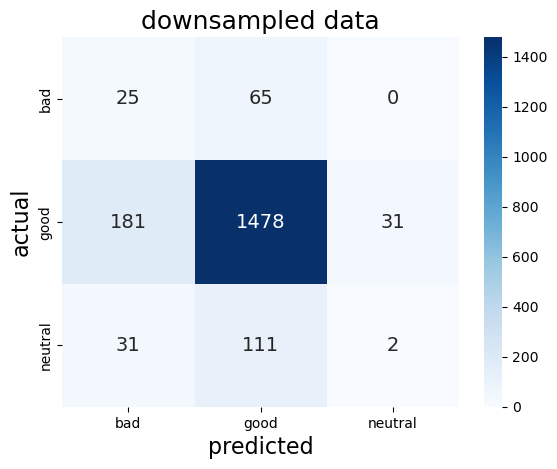

              precision    recall  f1-score   support

           0       0.11      0.28      0.15        90
           1       0.89      0.87      0.88      1690
           2       0.06      0.01      0.02       144

    accuracy                           0.78      1924
   macro avg       0.35      0.39      0.35      1924
weighted avg       0.79      0.78      0.79      1924



In [207]:
y_pred_probs = model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'downsampled data')

print(classification_report(y_val_labels, y_pred))

**Upsampled training data:**

In [195]:
model = buildmodel()

model.fit(padded_train_sequence_upsampled, 
          yy_train_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 8s 14ms/step - loss: 1.0680 - accuracy: 0.4067 - f1_macro: 0.4413 - f1_weighted: 0.4435 - kappa: 0.1698 - MatthewsCorrelationCoefficient: 0.1731 - val_loss: 0.9184 - val_accuracy: 0.7458 - val_f1_macro: 0.4369 - val_f1_weighted: 0.7814 - val_kappa: 0.2046 - val_MatthewsCorrelationCoefficient: 0.2218
Epoch 2/10
476/476 [==============================] - 6s 13ms/step - loss: 0.4377 - accuracy: 0.8405 - f1_macro: 0.8403 - f1_weighted: 0.8403 - kappa: 0.7608 - MatthewsCorrelationCoefficient: 0.7608 - val_loss: 0.7266 - val_accuracy: 0.6907 - val_f1_macro: 0.4580 - val_f1_weighted: 0.7524 - val_kappa: 0.2085 - val_MatthewsCorrelationCoefficient: 0.2507
Epoch 3/10
476/476 [==============================] - 6s 13ms/step - loss: 0.1546 - accuracy: 0.9520 - f1_macro: 0.9519 - f1_weighted: 0.9519 - kappa: 0.9280 - MatthewsCorrelationCoefficient: 0.9281 - val_loss: 0.6353 - val_accuracy: 0.8009 - val_f1_macro: 0.5021 - val_f1_weighted: 0.8227 

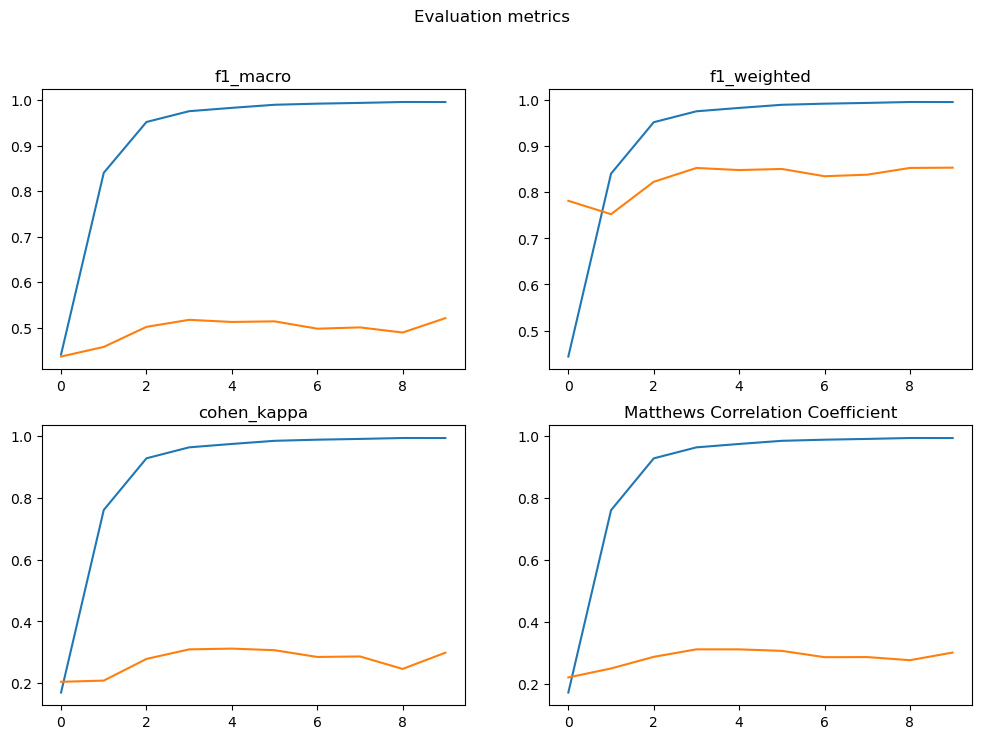

In [196]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 0s 6ms/step


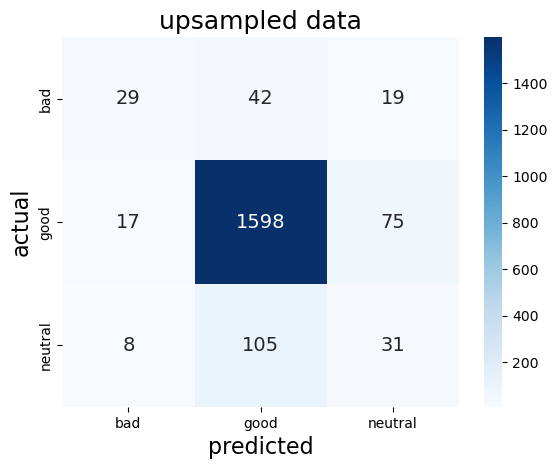

              precision    recall  f1-score   support

           0       0.54      0.32      0.40        90
           1       0.92      0.95      0.93      1690
           2       0.25      0.22      0.23       144

    accuracy                           0.86      1924
   macro avg       0.57      0.49      0.52      1924
weighted avg       0.85      0.86      0.85      1924



In [197]:
y_pred_probs = model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'upsampled data')

print(classification_report(y_val_labels, y_pred))

There is one more thing we can try before moving on. That is the SMOTE technique. This is another oversampling technique, where SMOTE uses k neigherest neighbours to add samples to the miniority classes.

In [194]:
sm = SMOTE(random_state = seed)

X_train_sm, y_train_sm = sm.fit_resample(padded_train_sequence_not_upsampled, yy_train_not_upsampled)

model = buildmodel(learning_rate = 0.001)

model.fit(X_train_sm, 
          y_train_sm,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          verbose = 1, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 8s 14ms/step - loss: 1.0983 - accuracy: 0.3338 - f1_macro: 0.3737 - f1_weighted: 0.3815 - kappa: 0.0954 - MatthewsCorrelationCoefficient: 0.1030 - val_loss: 1.0924 - val_accuracy: 0.8451 - val_f1_macro: 0.3316 - val_f1_weighted: 0.8110 - val_kappa: 0.0168 - val_MatthewsCorrelationCoefficient: 0.0193
Epoch 2/10
476/476 [==============================] - 7s 14ms/step - loss: 1.0925 - accuracy: 0.3527 - f1_macro: 0.2755 - f1_weighted: 0.2755 - kappa: 0.0291 - MatthewsCorrelationCoefficient: 0.0385 - val_loss: 1.0974 - val_accuracy: 0.7760 - val_f1_macro: 0.3270 - val_f1_weighted: 0.7778 - val_kappa: 0.0053 - val_MatthewsCorrelationCoefficient: 0.0053
Epoch 3/10
476/476 [==============================] - 7s 14ms/step - loss: 1.0848 - accuracy: 0.3666 - f1_macro: 0.3047 - f1_weighted: 0.3047 - kappa: 0.0499 - MatthewsCorrelationCoefficient: 0.0634 - val_loss: 1.0236 - val_accuracy: 0.8020 - val_f1_macro: 0.3443 - val_f1_weighted: 0.7930 

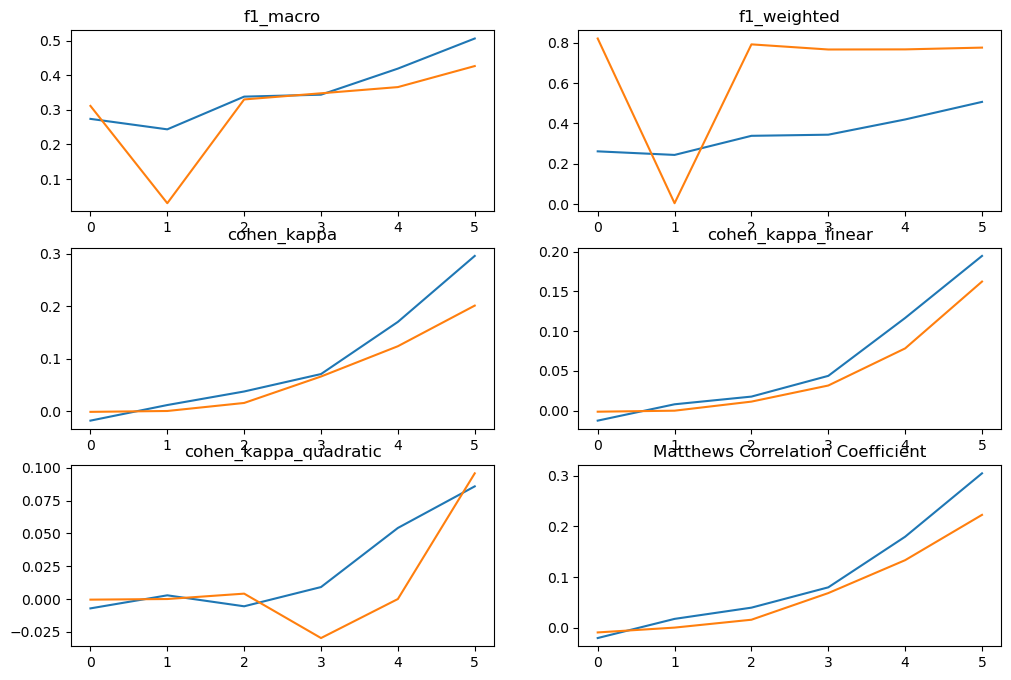

In [147]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 0s 2ms/step


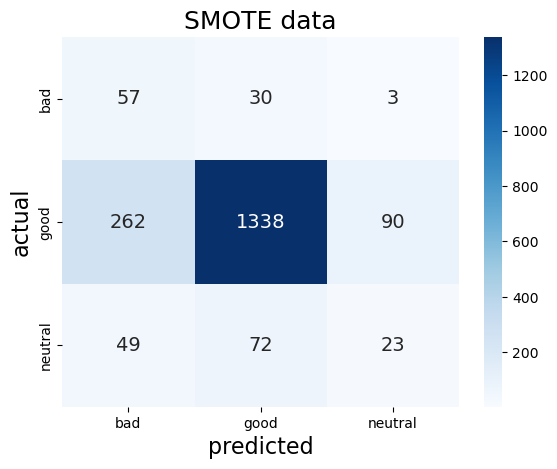

              precision    recall  f1-score   support

           0       0.15      0.63      0.25        90
           1       0.93      0.79      0.85      1690
           2       0.20      0.16      0.18       144

    accuracy                           0.74      1924
   macro avg       0.43      0.53      0.43      1924
weighted avg       0.84      0.74      0.78      1924



In [148]:
y_pred_probs = model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'SMOTE data')

print(classification_report(y_val_labels, y_pred))

Unfortunetaly, this isn't looking to great. Let's now try the most promising training data versions with class_weights, and see if that makes a difference. This means let's check the upsampled training data and the regular one.

**Regular training data with class weights:**

In [201]:
model = buildmodel()

model.fit(padded_train_sequence_not_upsampled, 
          yy_train_not_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          verbose = 1, 
          class_weight = class_weights)

Epoch 1/10
181/181 [==============================] - 4s 18ms/step - loss: 1.1032 - accuracy: 0.3790 - f1_macro: 0.2879 - f1_weighted: 0.5932 - kappa: 0.0152 - MatthewsCorrelationCoefficient: 0.0213 - val_loss: 1.1063 - val_accuracy: 0.0473 - val_f1_macro: 0.0342 - val_f1_weighted: 0.0052 - val_kappa: 3.6168e-04 - val_MatthewsCorrelationCoefficient: 0.0066
Epoch 2/10
181/181 [==============================] - 3s 16ms/step - loss: 1.0995 - accuracy: 0.0655 - f1_macro: 0.0786 - f1_weighted: 0.0330 - kappa: 0.0018 - MatthewsCorrelationCoefficient: 0.0055 - val_loss: 1.0816 - val_accuracy: 0.0748 - val_f1_macro: 0.0464 - val_f1_weighted: 0.0104 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/10
181/181 [==============================] - 3s 16ms/step - loss: 1.0987 - accuracy: 0.3632 - f1_macro: 0.2429 - f1_weighted: 0.4730 - kappa: 0.0066 - MatthewsCorrelationCoefficient: 0.0114 - val_loss: 1.0853 - val_accuracy: 0.7131 - val_f1_macro: 0.3392 - val_f1_weigh

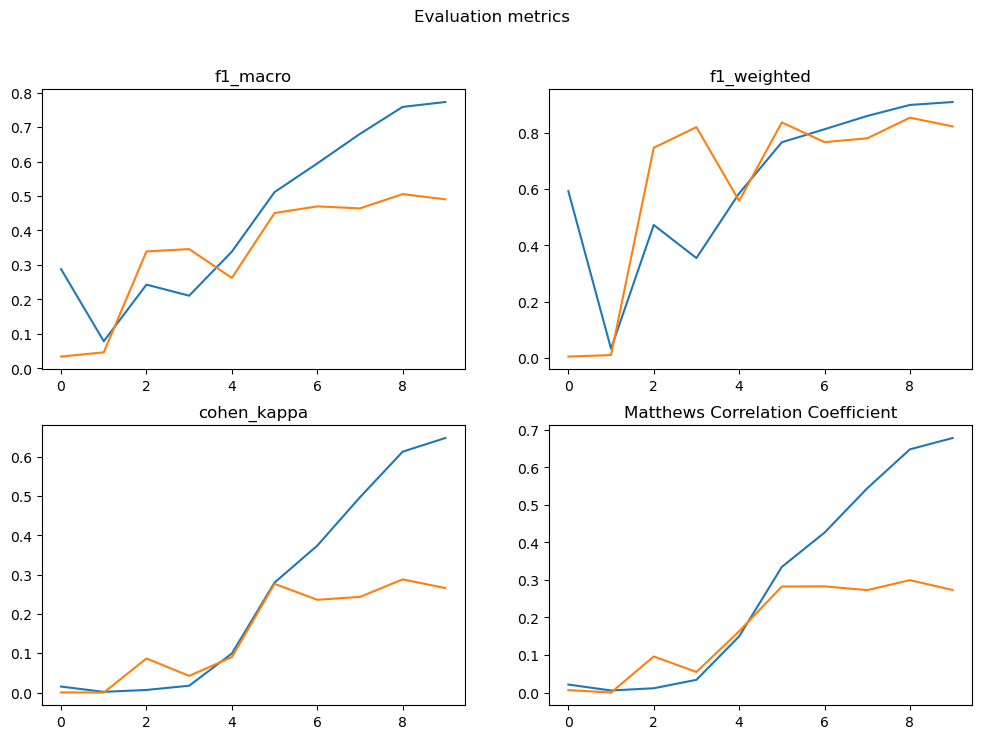

In [202]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 0s 5ms/step


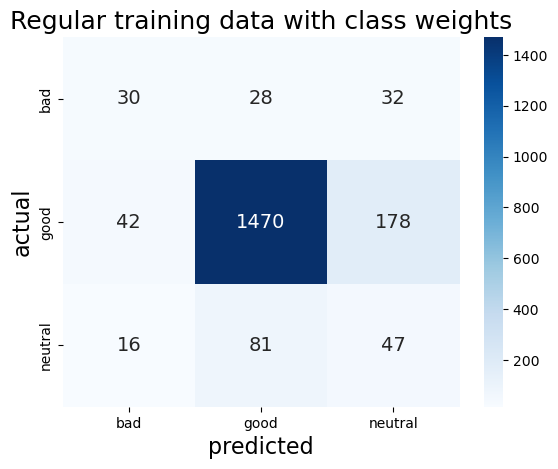

              precision    recall  f1-score   support

           0       0.34      0.33      0.34        90
           1       0.93      0.87      0.90      1690
           2       0.18      0.33      0.23       144

    accuracy                           0.80      1924
   macro avg       0.48      0.51      0.49      1924
weighted avg       0.85      0.80      0.82      1924



In [204]:
y_pred_probs = model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'Regular training data with class weights')

print(classification_report(y_val_labels, y_pred))

The model is predicting a lot more of the minority classes here, but getting them wrong and the scores are slightly worse.

**Upsampled training data with class weights:**

In [198]:
model = buildmodel()

model.fit(padded_train_sequence_upsampled, 
          yy_train_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = class_weights)

Epoch 1/10
476/476 [==============================] - 8s 16ms/step - loss: 2.7492 - accuracy: 0.4288 - f1_macro: 0.4517 - f1_weighted: 0.4445 - kappa: 0.2412 - MatthewsCorrelationCoefficient: 0.2976 - val_loss: 2.7641 - val_accuracy: 0.0743 - val_f1_macro: 0.0884 - val_f1_weighted: 0.0160 - val_kappa: 0.0148 - val_MatthewsCorrelationCoefficient: 0.0419
Epoch 2/10
476/476 [==============================] - 7s 15ms/step - loss: 0.9867 - accuracy: 0.6418 - f1_macro: 0.5165 - f1_weighted: 0.5165 - kappa: 0.4627 - MatthewsCorrelationCoefficient: 0.5377 - val_loss: 2.6923 - val_accuracy: 0.0790 - val_f1_macro: 0.1017 - val_f1_weighted: 0.0181 - val_kappa: 0.0084 - val_MatthewsCorrelationCoefficient: 0.0350
Epoch 3/10
476/476 [==============================] - 7s 14ms/step - loss: 0.5259 - accuracy: 0.6750 - f1_macro: 0.5633 - f1_weighted: 0.5633 - kappa: 0.5125 - MatthewsCorrelationCoefficient: 0.5928 - val_loss: 1.8977 - val_accuracy: 0.1668 - val_f1_macro: 0.1730 - val_f1_weighted: 0.1819 

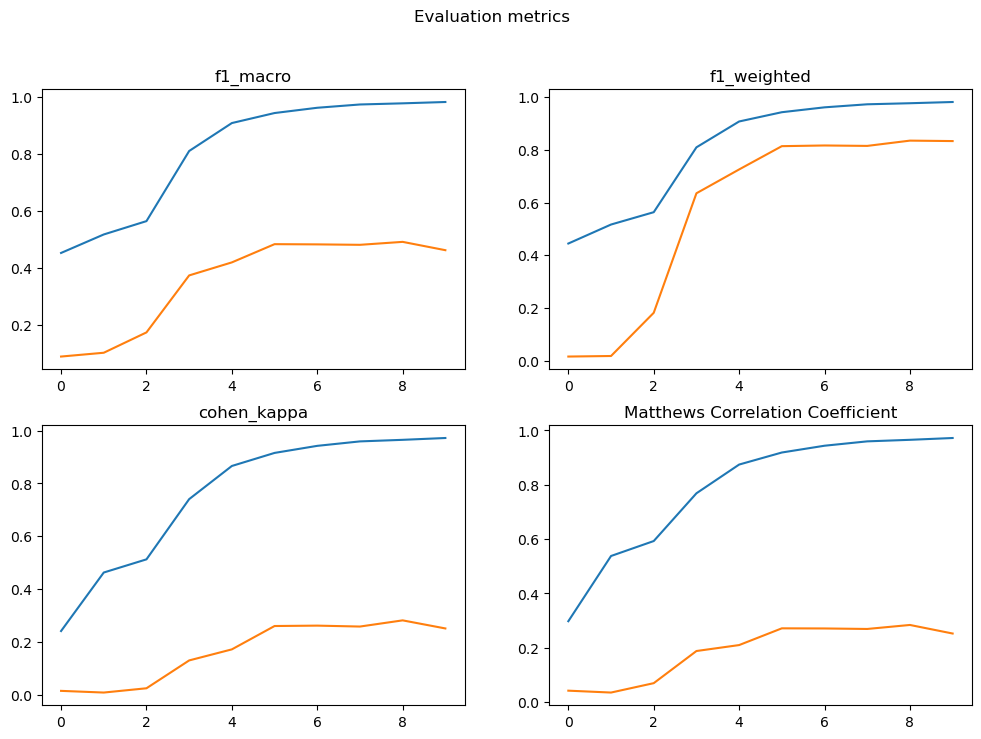

In [199]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 0s 6ms/step


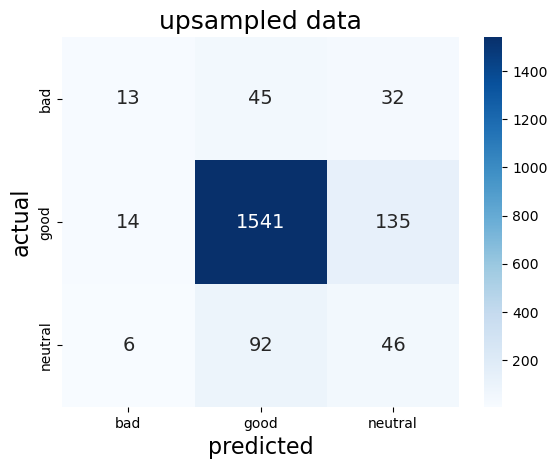

              precision    recall  f1-score   support

           0       0.39      0.14      0.21        90
           1       0.92      0.91      0.92      1690
           2       0.22      0.32      0.26       144

    accuracy                           0.83      1924
   macro avg       0.51      0.46      0.46      1924
weighted avg       0.84      0.83      0.83      1924



In [200]:
y_pred_probs = model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'upsampled data')

print(classification_report(y_val_labels, y_pred))

Similar issue here, so adding class weights doesn't seem to help.

Now let's start **GridSearch**, and tune for the best model.

In [110]:
estimator = KerasClassifier(build_fn = buildmodel, 
                            verbose = 1)

param_grid = {'epochs': [4, 6, 8], 'batch_size': [16, 32, 64]}

#cv=3 just to speed up run times
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring = 'f1_macro', cv = 3)

grid.fit(padded_train_sequence, y_train)

Epoch 1/4


C:\Users\RaviB\AppData\Local\Temp\ipykernel_17960\1000649331.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn = buildmodel,


321/321 [==============================] - 3s 8ms/step - loss: 0.5410 - accuracy: 0.8688 - f1_score: 0.8154
Epoch 2/4
321/321 [==============================] - 2s 8ms/step - loss: 0.4872 - accuracy: 0.8752 - f1_score: 0.8170
Epoch 3/4
 29/321 [=>............................] - ETA: 2s - loss: 0.5103 - accuracy: 0.8664 - f1_score: 0.8044

KeyboardInterrupt: 

In [314]:
grid.best_params_

{'batch_size': 16, 'epochs': 8}

In [315]:
print('Grid search training f1 score:', f1_score(grid.predict(padded_train_sequence), y_train, average = 'macro'))

nn_grid_pred = grid.predict(padded_test_sequence)
print('Grid search testing f1 score:', f1_score(nn_grid_pred, y_test, average = 'macro'))

Grid search training f1 score: 0.9373667542882937
Grid search testing f1 score: 0.9109838542422806


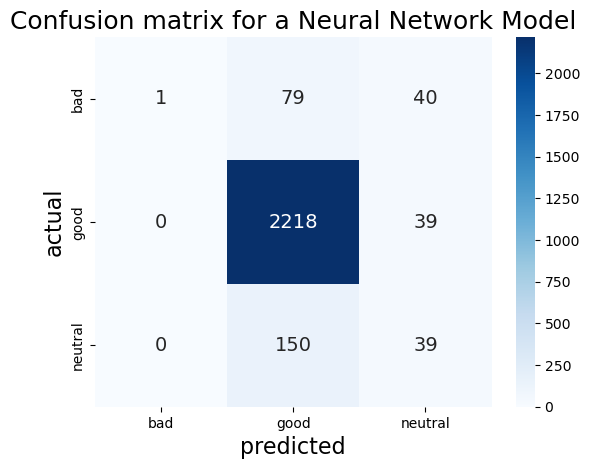

In [316]:
#now let's get the confusion matrix to see how it does
con_mat = confusion_matrix(y_test, nn_grid_pred)

sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["bad", "good", "neutral"], yticklabels = ["bad", "good", "neutral"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for a Neural Network Model', fontsize=18)
plt.show()

### LSTM

Now let's try a network with LSTM's.

In [215]:
def buildLSTM(learning_rate = 0.001, dropout = 0.3):
    model= Sequential([
        Embedding(max_vocab, 1000, input_length = 500),
        #Bidirectional(LSTM(100)),
        LSTM(25),
        Dropout(dropout),
        Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])
    
    return model

**LSTM Model with regular training data:**

In [211]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_not_upsampled, 
          yy_train_not_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
181/181 [==============================] - 11s 48ms/step - loss: 0.4695 - accuracy: 0.8728 - f1_macro: 0.3914 - f1_weighted: 0.8335 - kappa: 0.1111 - kappa_linear: 0.0775 - kappa_quadratic: 0.0447 - MatthewsCorrelationCoefficient: 0.1474 - val_loss: 0.3638 - val_accuracy: 0.8789 - val_f1_macro: 0.3335 - val_f1_weighted: 0.8269 - val_kappa: 0.0405 - val_kappa_linear: 0.0343 - val_kappa_quadratic: 0.0220 - val_MatthewsCorrelationCoefficient: 0.1021
Epoch 2/10
181/181 [==============================] - 7s 41ms/step - loss: 0.2770 - accuracy: 0.8971 - f1_macro: 0.5092 - f1_weighted: 0.8686 - kappa: 0.3146 - kappa_linear: 0.2742 - kappa_quadratic: 0.1962 - MatthewsCorrelationCoefficient: 0.3854 - val_loss: 0.3760 - val_accuracy: 0.8779 - val_f1_macro: 0.3900 - val_f1_weighted: 0.8388 - val_kappa: 0.1434 - val_kappa_linear: 0.1114 - val_kappa_quadratic: 0.0492 - val_MatthewsCorrelationCoefficient: 0.1932
Epoch 3/10
181/181 [==============================] - 7s 41ms/step - loss: 0.

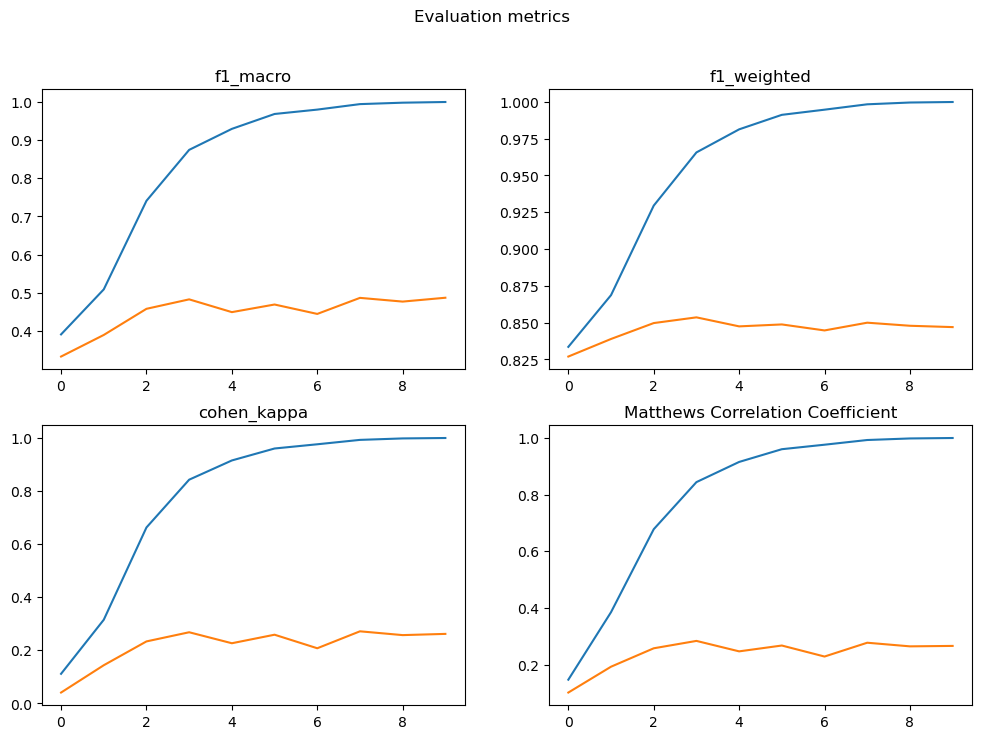

In [212]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 14ms/step


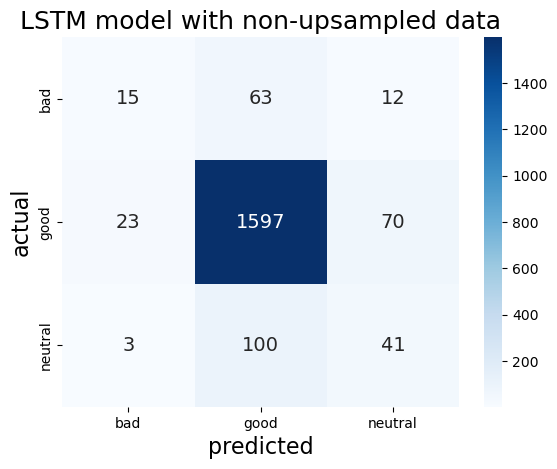

              precision    recall  f1-score   support

           0       0.37      0.17      0.23        90
           1       0.91      0.94      0.93      1690
           2       0.33      0.28      0.31       144

    accuracy                           0.86      1924
   macro avg       0.54      0.47      0.49      1924
weighted avg       0.84      0.86      0.85      1924



In [213]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with non-upsampled data')

print(classification_report(y_val_labels, y_pred))

**LSTM Model with downsampled training data:**

In [216]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_downsampled, 
          yy_train_downsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
26/26 [==============================] - 5s 109ms/step - loss: 1.0675 - accuracy: 0.4790 - f1_macro: 0.5380 - f1_weighted: 0.7281 - kappa: 0.3783 - MatthewsCorrelationCoefficient: 0.3843 - val_loss: 0.9612 - val_accuracy: 0.7032 - val_f1_macro: 0.4212 - val_f1_weighted: 0.7561 - val_kappa: 0.1778 - val_MatthewsCorrelationCoefficient: 0.2025
Epoch 2/10
26/26 [==============================] - 2s 71ms/step - loss: 0.7562 - accuracy: 0.8259 - f1_macro: 0.8229 - f1_weighted: 0.8229 - kappa: 0.7389 - MatthewsCorrelationCoefficient: 0.7485 - val_loss: 0.8346 - val_accuracy: 0.6325 - val_f1_macro: 0.4157 - val_f1_weighted: 0.7069 - val_kappa: 0.1776 - val_MatthewsCorrelationCoefficient: 0.2271
Epoch 3/10
26/26 [==============================] - 2s 71ms/step - loss: 0.2916 - accuracy: 0.9420 - f1_macro: 0.9420 - f1_weighted: 0.9420 - kappa: 0.9130 - MatthewsCorrelationCoefficient: 0.9130 - val_loss: 0.8760 - val_accuracy: 0.6279 - val_f1_macro: 0.4064 - val_f1_weighted: 0.7044 - val

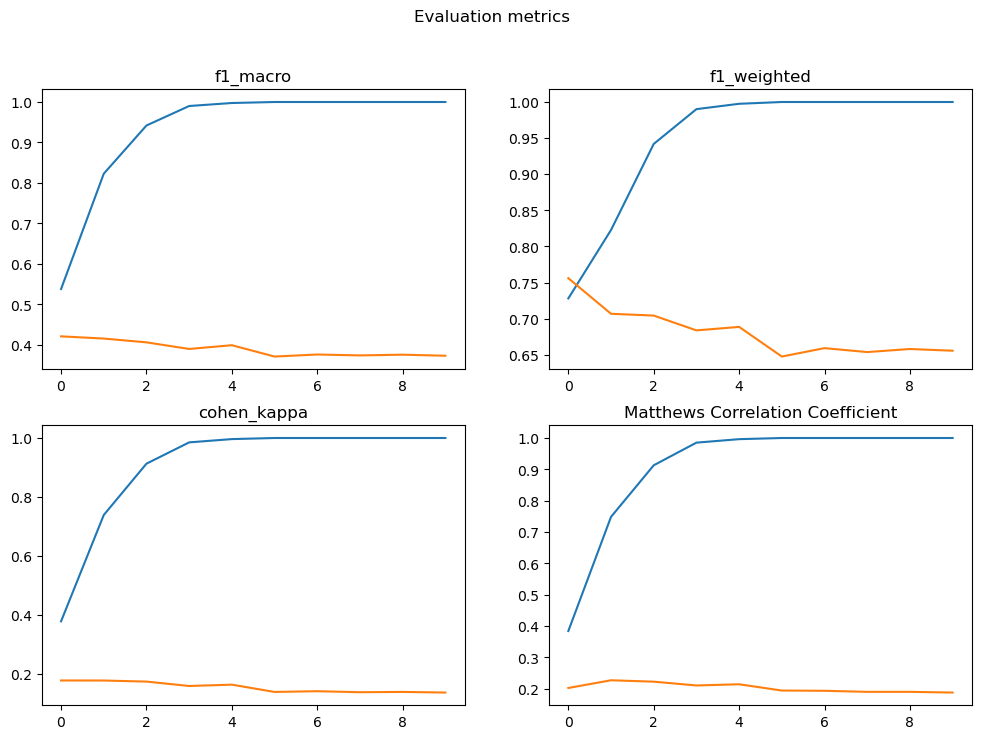

In [217]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


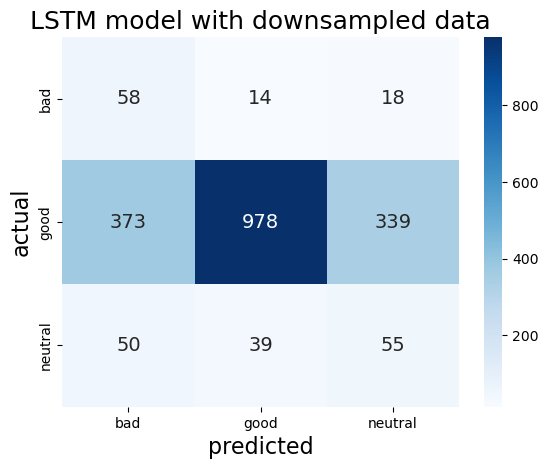

              precision    recall  f1-score   support

           0       0.12      0.64      0.20        90
           1       0.95      0.58      0.72      1690
           2       0.13      0.38      0.20       144

    accuracy                           0.57      1924
   macro avg       0.40      0.54      0.37      1924
weighted avg       0.85      0.57      0.66      1924



In [218]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with downsampled data')

print(classification_report(y_val_labels, y_pred))

**LSTM Model with upsampled training data:**

In [219]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_upsampled, 
          yy_train_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 18s 34ms/step - loss: 0.2805 - accuracy: 0.8981 - f1_macro: 0.8621 - f1_weighted: 0.8602 - kappa: 0.7911 - MatthewsCorrelationCoefficient: 0.7933 - val_loss: 0.5361 - val_accuracy: 0.8503 - val_f1_macro: 0.4716 - val_f1_weighted: 0.8410 - val_kappa: 0.2446 - val_MatthewsCorrelationCoefficient: 0.2470
Epoch 2/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0410 - accuracy: 0.9892 - f1_macro: 0.9892 - f1_weighted: 0.9892 - kappa: 0.9838 - MatthewsCorrelationCoefficient: 0.9839 - val_loss: 0.6674 - val_accuracy: 0.8597 - val_f1_macro: 0.4860 - val_f1_weighted: 0.8488 - val_kappa: 0.2763 - val_MatthewsCorrelationCoefficient: 0.2803
Epoch 3/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0163 - accuracy: 0.9961 - f1_macro: 0.9961 - f1_weighted: 0.9961 - kappa: 0.9942 - MatthewsCorrelationCoefficient: 0.9942 - val_loss: 0.8987 - val_accuracy: 0.8098 - val_f1_macro: 0.4599 - val_f1_weighted: 0.82

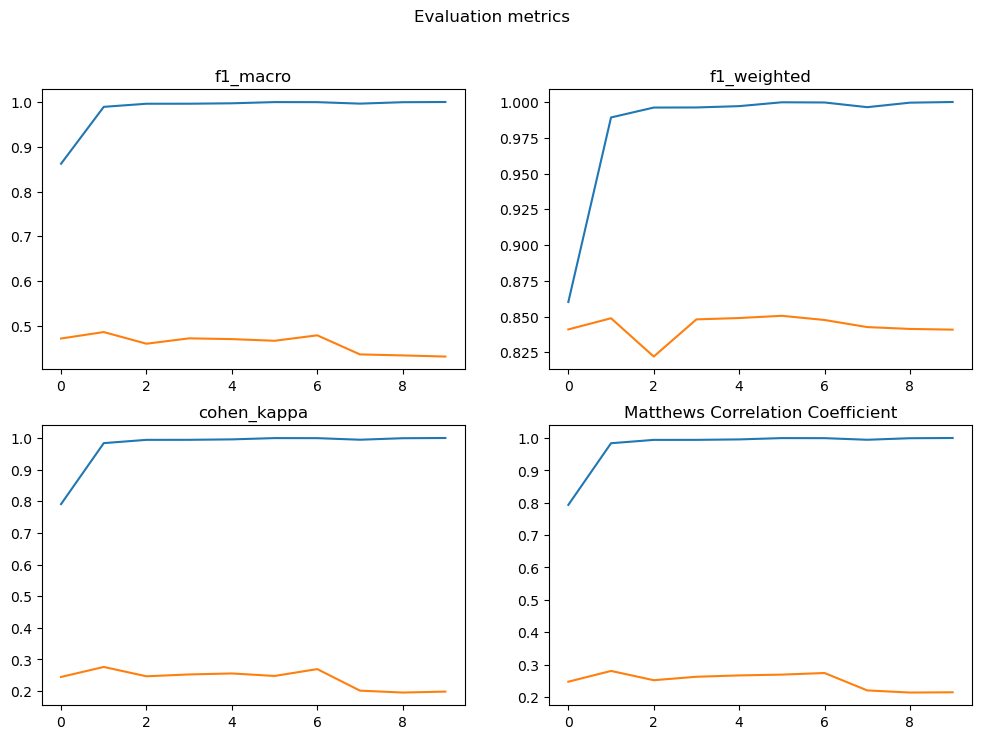

In [220]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


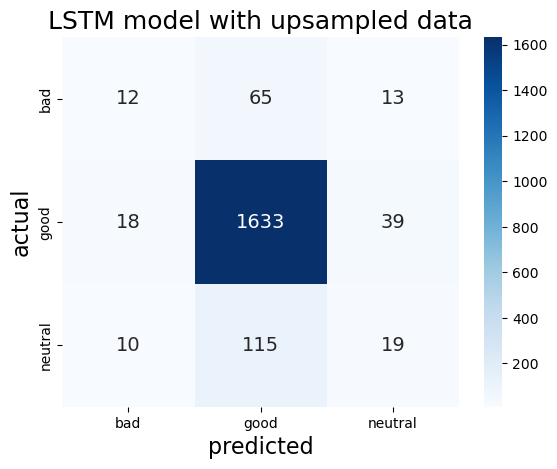

              precision    recall  f1-score   support

           0       0.30      0.13      0.18        90
           1       0.90      0.97      0.93      1690
           2       0.27      0.13      0.18       144

    accuracy                           0.86      1924
   macro avg       0.49      0.41      0.43      1924
weighted avg       0.83      0.86      0.84      1924



In [221]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with upsampled data')

print(classification_report(y_val_labels, y_pred))

**LSTM Model with SMOTE training data:**

In [225]:
LSTM_model = buildLSTM(learning_rate = 0.001, dropout = 0.3)

LSTM_model.fit(X_train_sm, 
          y_train_sm,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 19s 34ms/step - loss: 0.8551 - accuracy: 0.5612 - f1_macro: 0.5689 - f1_weighted: 0.5887 - kappa: 0.3828 - MatthewsCorrelationCoefficient: 0.3833 - val_loss: 0.6612 - val_accuracy: 0.7594 - val_f1_macro: 0.4550 - val_f1_weighted: 0.7942 - val_kappa: 0.2268 - val_MatthewsCorrelationCoefficient: 0.2432
Epoch 2/10
476/476 [==============================] - 15s 33ms/step - loss: 0.6699 - accuracy: 0.6728 - f1_macro: 0.6707 - f1_weighted: 0.6707 - kappa: 0.5092 - MatthewsCorrelationCoefficient: 0.5095 - val_loss: 0.7074 - val_accuracy: 0.7328 - val_f1_macro: 0.4332 - val_f1_weighted: 0.7775 - val_kappa: 0.2071 - val_MatthewsCorrelationCoefficient: 0.2284
Epoch 3/10
476/476 [==============================] - 16s 33ms/step - loss: 0.5209 - accuracy: 0.7678 - f1_macro: 0.7670 - f1_weighted: 0.7670 - kappa: 0.6517 - MatthewsCorrelationCoefficient: 0.6518 - val_loss: 0.6709 - val_accuracy: 0.7786 - val_f1_macro: 0.4701 - val_f1_weighted: 0.80

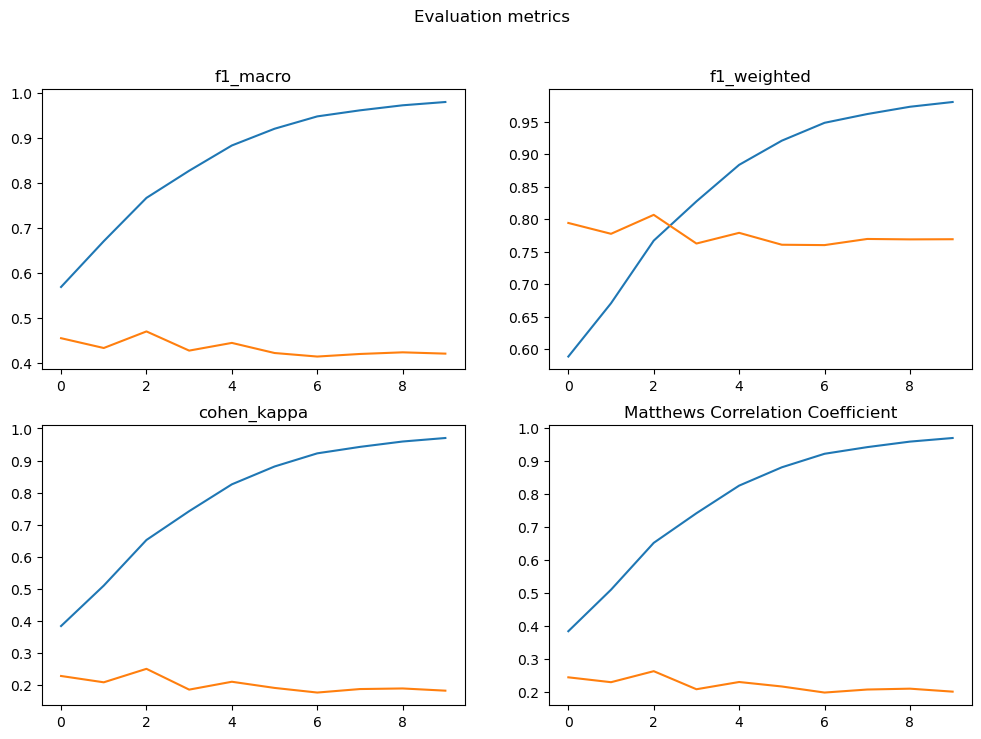

In [226]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


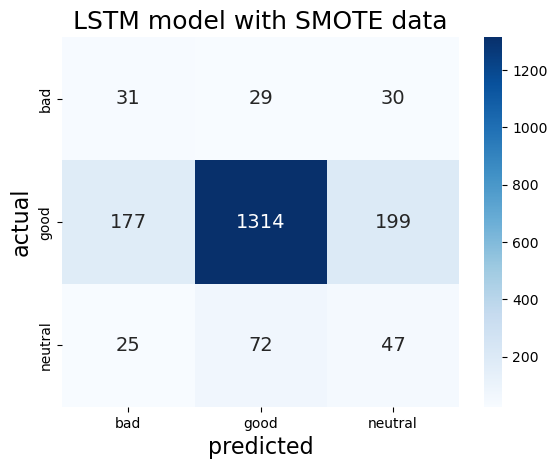

              precision    recall  f1-score   support

           0       0.13      0.34      0.19        90
           1       0.93      0.78      0.85      1690
           2       0.17      0.33      0.22       144

    accuracy                           0.72      1924
   macro avg       0.41      0.48      0.42      1924
weighted avg       0.83      0.72      0.77      1924



In [227]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with SMOTE data')

print(classification_report(y_val_labels, y_pred))

Again, let's look at the most promising models but with class weights this time, to see if they help.

**LSTM model with regular training data and class weights:**

In [222]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_not_upsampled, 
          yy_train_not_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = class_weights)

Epoch 1/10
181/181 [==============================] - 10s 42ms/step - loss: 0.9892 - accuracy: 0.7557 - f1_macro: 0.4485 - f1_weighted: 0.8041 - kappa: 0.2077 - MatthewsCorrelationCoefficient: 0.2138 - val_loss: 0.7720 - val_accuracy: 0.6533 - val_f1_macro: 0.4172 - val_f1_weighted: 0.7265 - val_kappa: 0.1973 - val_MatthewsCorrelationCoefficient: 0.2462
Epoch 2/10
181/181 [==============================] - 7s 36ms/step - loss: 0.5160 - accuracy: 0.8359 - f1_macro: 0.6528 - f1_weighted: 0.8611 - kappa: 0.4934 - MatthewsCorrelationCoefficient: 0.5363 - val_loss: 0.6173 - val_accuracy: 0.7302 - val_f1_macro: 0.4518 - val_f1_weighted: 0.7754 - val_kappa: 0.2270 - val_MatthewsCorrelationCoefficient: 0.2566
Epoch 3/10
181/181 [==============================] - 7s 36ms/step - loss: 0.1969 - accuracy: 0.9198 - f1_macro: 0.8242 - f1_weighted: 0.9283 - kappa: 0.7126 - MatthewsCorrelationCoefficient: 0.7381 - val_loss: 0.5792 - val_accuracy: 0.7978 - val_f1_macro: 0.4872 - val_f1_weighted: 0.8194

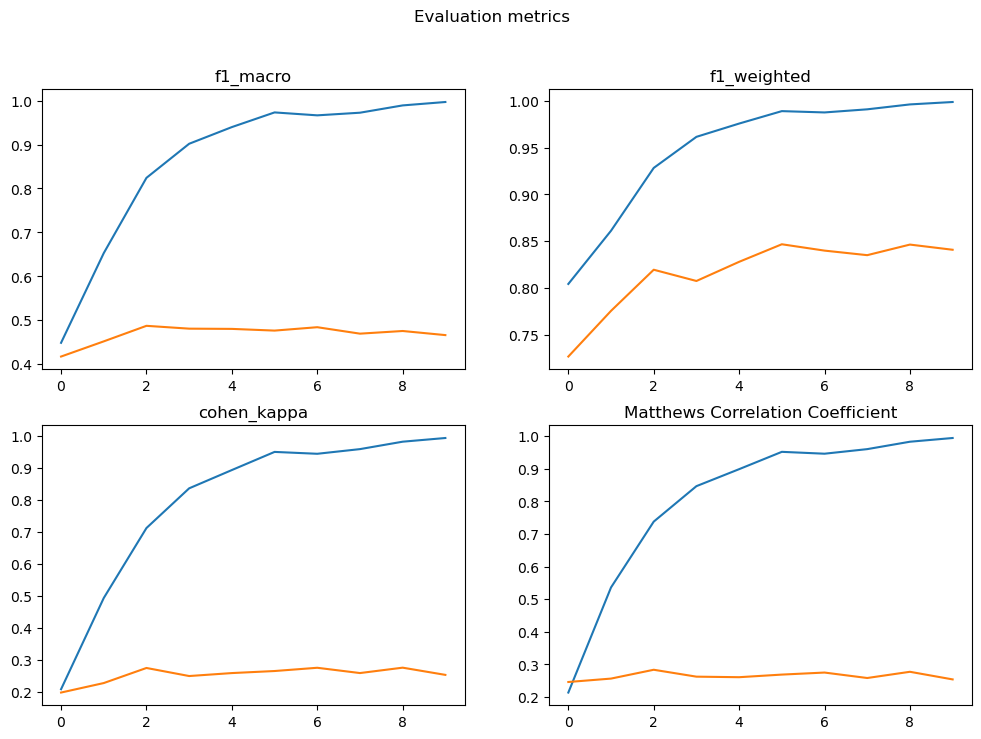

In [223]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


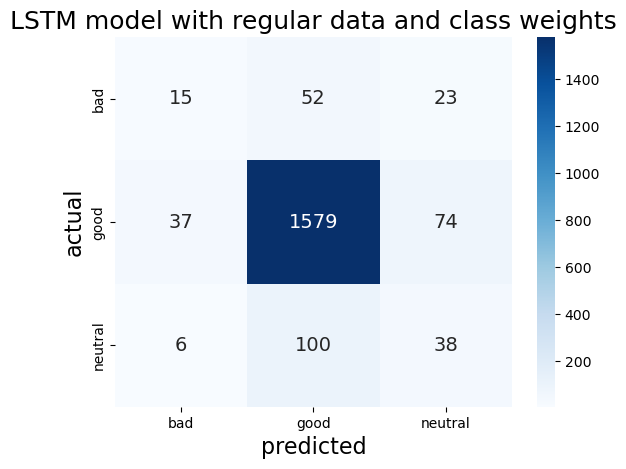

              precision    recall  f1-score   support

           0       0.26      0.17      0.20        90
           1       0.91      0.93      0.92      1690
           2       0.28      0.26      0.27       144

    accuracy                           0.85      1924
   macro avg       0.48      0.45      0.47      1924
weighted avg       0.83      0.85      0.84      1924



In [224]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with regular data and class weights')

print(classification_report(y_val_labels, y_pred))

**LSTM model with upsampled training data and class weights:**

In [230]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_upsampled, 
          yy_train_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = class_weights)

Epoch 1/10
476/476 [==============================] - 19s 35ms/step - loss: 0.7131 - accuracy: 0.7836 - f1_macro: 0.7461 - f1_weighted: 0.7360 - kappa: 0.6359 - MatthewsCorrelationCoefficient: 0.6666 - val_loss: 0.8595 - val_accuracy: 0.7531 - val_f1_macro: 0.4523 - val_f1_weighted: 0.7884 - val_kappa: 0.2179 - val_MatthewsCorrelationCoefficient: 0.2362
Epoch 2/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0643 - accuracy: 0.9726 - f1_macro: 0.9724 - f1_weighted: 0.9724 - kappa: 0.9589 - MatthewsCorrelationCoefficient: 0.9597 - val_loss: 0.6753 - val_accuracy: 0.8280 - val_f1_macro: 0.4658 - val_f1_weighted: 0.8308 - val_kappa: 0.2502 - val_MatthewsCorrelationCoefficient: 0.2509
Epoch 3/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0621 - accuracy: 0.9807 - f1_macro: 0.9806 - f1_weighted: 0.9806 - kappa: 0.9710 - MatthewsCorrelationCoefficient: 0.9714 - val_loss: 0.9153 - val_accuracy: 0.7651 - val_f1_macro: 0.4581 - val_f1_weighted: 0.79

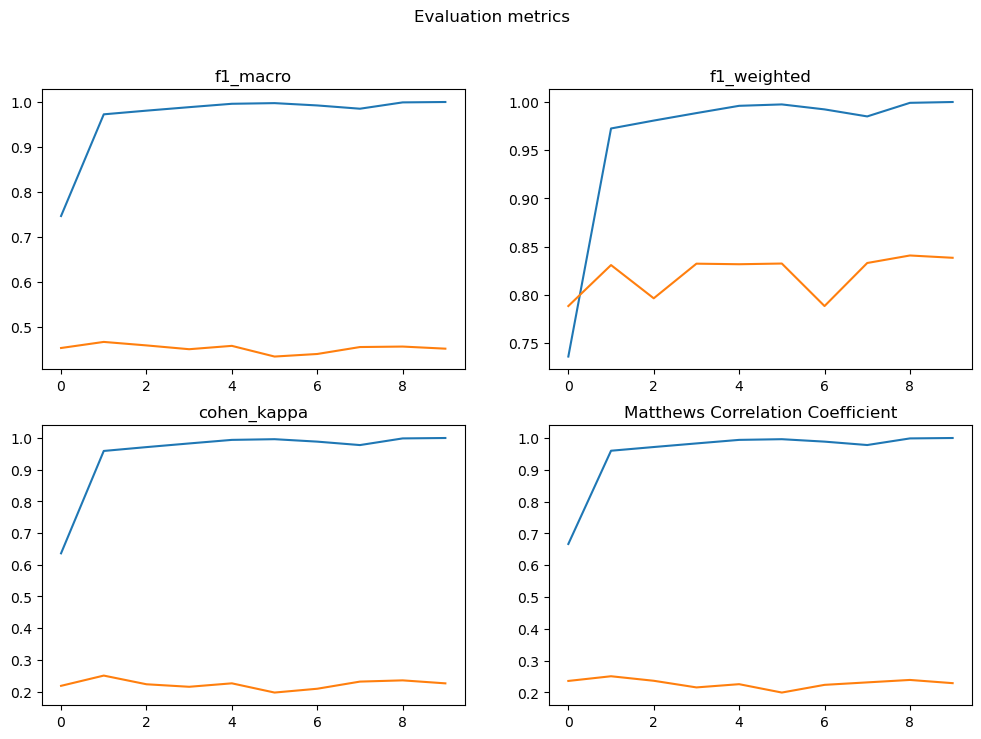

In [231]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


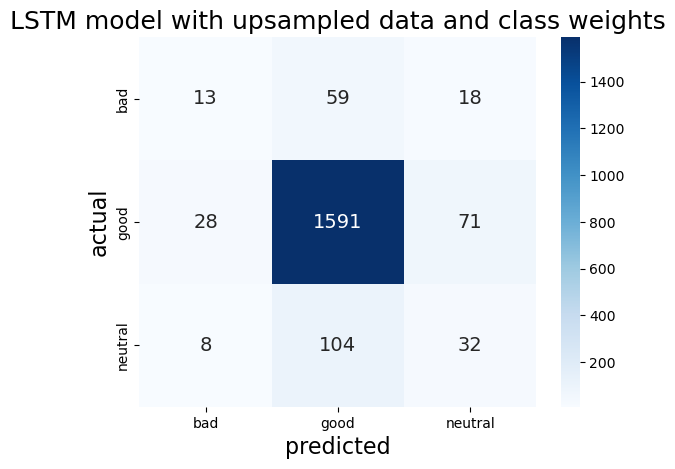

              precision    recall  f1-score   support

           0       0.27      0.14      0.19        90
           1       0.91      0.94      0.92      1690
           2       0.26      0.22      0.24       144

    accuracy                           0.85      1924
   macro avg       0.48      0.44      0.45      1924
weighted avg       0.83      0.85      0.84      1924



In [232]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with upsampled data and class weights')

print(classification_report(y_val_labels, y_pred))

Now let's do **grid search** for the best LSTM model, which in this case was the regular training data with no weights.

In [257]:
def buildLSTM():
    model= Sequential([
        Embedding(max_vocab, 1000, input_length=500),
        Bidirectional(LSTM(32, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(16)),
        Dropout(0.3),
        Dense(64,activation='relu'),
        Dense(3,activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average='weighted')])
    return(model)

estimator2 = KerasClassifier(build_fn=buildmodel, verbose = 1)

param_grid2 = {'epochs': [4, 6, 8], 'batch_size': [32, 64, 128]}

#cv=3 just to speed up run times
LSTM_grid = GridSearchCV(estimator=estimator2, param_grid=param_grid2, scoring = 'f1_weighted', cv=3)

LSTM_grid.fit(padded_train_sequence, y_train)

Epoch 1/4


C:\Users\RaviB\AppData\Local\Temp\ipykernel_17648\1717515851.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator2 = KerasClassifier(build_fn=buildmodel, verbose=2)


161/161 - 2s - loss: 0.5127 - accuracy: 0.8776 - f1_score: 0.8232 - 2s/epoch - 13ms/step
Epoch 2/4
161/161 - 1s - loss: 0.4610 - accuracy: 0.8801 - f1_score: 0.8240 - 1s/epoch - 8ms/step
Epoch 3/4
161/161 - 1s - loss: 0.4516 - accuracy: 0.8801 - f1_score: 0.8240 - 1s/epoch - 7ms/step
Epoch 4/4
161/161 - 1s - loss: 0.4365 - accuracy: 0.8801 - f1_score: 0.8240 - 1s/epoch - 8ms/step
Epoch 1/4
161/161 - 2s - loss: 0.5110 - accuracy: 0.8737 - f1_score: 0.8208 - 2s/epoch - 11ms/step
Epoch 2/4
161/161 - 1s - loss: 0.4630 - accuracy: 0.8791 - f1_score: 0.8226 - 1s/epoch - 7ms/step
Epoch 3/4
161/161 - 1s - loss: 0.4467 - accuracy: 0.8791 - f1_score: 0.8226 - 1s/epoch - 8ms/step
Epoch 4/4
161/161 - 1s - loss: 0.4313 - accuracy: 0.8791 - f1_score: 0.8226 - 1s/epoch - 8ms/step
Epoch 1/4
161/161 - 2s - loss: 0.5245 - accuracy: 0.8702 - f1_score: 0.8182 - 2s/epoch - 12ms/step
Epoch 2/4
161/161 - 1s - loss: 0.4667 - accuracy: 0.8782 - f1_score: 0.8212 - 1s/epoch - 8ms/step
Epoch 3/4
161/161 - 1s - lo

Epoch 1/8
81/81 - 1s - loss: 0.5558 - accuracy: 0.8688 - f1_score: 0.8196 - 1s/epoch - 18ms/step
Epoch 2/8
81/81 - 1s - loss: 0.4674 - accuracy: 0.8801 - f1_score: 0.8240 - 863ms/epoch - 11ms/step
Epoch 3/8
81/81 - 1s - loss: 0.4594 - accuracy: 0.8801 - f1_score: 0.8240 - 837ms/epoch - 10ms/step
Epoch 4/8
81/81 - 1s - loss: 0.4505 - accuracy: 0.8801 - f1_score: 0.8240 - 828ms/epoch - 10ms/step
Epoch 5/8
81/81 - 1s - loss: 0.4433 - accuracy: 0.8801 - f1_score: 0.8240 - 823ms/epoch - 10ms/step
Epoch 6/8
81/81 - 1s - loss: 0.4289 - accuracy: 0.8801 - f1_score: 0.8240 - 821ms/epoch - 10ms/step
Epoch 7/8
81/81 - 1s - loss: 0.4004 - accuracy: 0.8801 - f1_score: 0.8240 - 833ms/epoch - 10ms/step
Epoch 8/8
81/81 - 1s - loss: 0.3463 - accuracy: 0.8803 - f1_score: 0.8246 - 819ms/epoch - 10ms/step
Epoch 1/8
81/81 - 1s - loss: 0.5634 - accuracy: 0.8768 - f1_score: 0.8225 - 1s/epoch - 18ms/step
Epoch 2/8
81/81 - 1s - loss: 0.4623 - accuracy: 0.8791 - f1_score: 0.8226 - 818ms/epoch - 10ms/step
Epoch 

Epoch 6/8
241/241 - 2s - loss: 0.2630 - accuracy: 0.9025 - f1_score: 0.8833 - 2s/epoch - 8ms/step
Epoch 7/8
241/241 - 2s - loss: 0.2344 - accuracy: 0.9097 - f1_score: 0.8980 - 2s/epoch - 8ms/step
Epoch 8/8
241/241 - 2s - loss: 0.2038 - accuracy: 0.9194 - f1_score: 0.9108 - 2s/epoch - 8ms/step


GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F291133D90>,
             param_grid={'batch_size': [32, 64, 128], 'epochs': [4, 6, 8]},
             scoring='f1_weighted')

In [258]:
LSTM_grid.best_params_

{'batch_size': 32, 'epochs': 8}

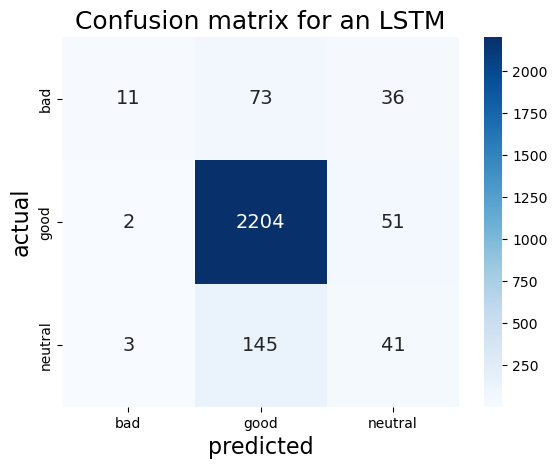

In [261]:
LSTM_grid_pred = LSTM_grid.predict(padded_test_sequence)

con_mat = confusion_matrix(y_test, LSTM_grid_pred)

sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["bad", "good", "neutral"], yticklabels = ["bad", "good", "neutral"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for an LSTM', fontsize=18)
plt.show()

Now let's look at this best model individually and look at the f1 scores over the epochs.